<a href="https://colab.research.google.com/github/YangchenHuang/Algorithmic_Trading/blob/master/Evolution%20Strategy_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.0.1-cp36-none-any.whl size=10032 sha256=2af3c49bcbeb78b6695826fcfc11dd582cfea74baaff988c641c4f2861aaf196
  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


In [0]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from bayes_opt import BayesianOptimization

In [44]:
!rm -rf Algorithmic_Trading
!git clone https://github.com/YangchenHuang/Algorithmic_Trading

Cloning into 'Algorithmic_Trading'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 83 (delta 29), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (83/83), done.


In [45]:
df = pd.read_csv('./Algorithmic_Trading/dataset/TEVA.csv')
df.head()

PERMNO      date  PERMCO    PRC       VOL  CFACPR  OPENPRC
0   75652  20070103    5310  31.26   8475482       1    31.39
1   75652  20070104    5310  31.64  11550755       1    31.26
2   75652  20070105    5310  32.21   9297630       1    31.68
3   75652  20070108    5310  32.88  10214669       1    32.50
4   75652  20070109    5310  32.82   8120628       1    32.99

In [0]:
data = df[['PRC', 'VOL', 'OPENPRC']].to_numpy().flatten()
data = data.tolist()
close = df['PRC'].tolist()
window_size = 30
skip = 5
l = len(close) - 1
test_size=l//2
dev_size=0

In [0]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d*3 : (t + 1)*3] if d >= 0 else -d * [data[0], data[1], data[2]] + data[0 : (t + 1)*3]
    res = []
    for i in range(n - 1):
        for j in range(3):
            if block[i*3+j]==0:
                res.append(0)
            else:
                res.append((block[(i + 1)*3+j] - block[i*3+j])/block[i*3+j])
    return np.array([res])

In [0]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate, validate, buy, model
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.fsigma = sigma
        self.validate = validate
        self.buy = buy
        self.model=model

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        reward_list=[]
        max_validate=0
        best_model=self.model
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            # for k in range(self.population_size):
            #     if rewards[k]>0:
            #         self.siglist[k] = np.clip(self.sigma*(rmax-rewards[k])/rran, 0.00001*self.sigma, self.sigma)
            #     if rewards[k]<=0:
            #         self.siglist[k]=self.sigma
            # print(self.siglist)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    * np.dot(A.T, rewards).T
                )
            final_reward=self.reward_function(self.weights)
            if i>0:
                if final_reward<=0:
                    self.sigma = self.fsigma
                if self.sigma > self.fsigma/2:
                    if final_reward>max(reward_list):
                        self.sigma=self.sigma*np.clip((final_reward-max(reward_list))/(final_reward+1e-10),0.95, 0.999)
                    if final_reward<np.average(reward_list):
                        self.sigma=min(self.sigma*np.clip(np.average(reward_list)/(np.average(reward_list)-final_reward+1e-10),1.001, 1.05),min(2*self.fsigma, 0.99))
                elif self.sigma > self.fsigma/4:
                    if final_reward>max(reward_list):
                        self.sigma=self.sigma*np.clip((final_reward-max(reward_list))/(final_reward+1e-10),0.9, 0.95)
                elif self.sigma > self.fsigma/10:
                    if final_reward>max(reward_list):
                        self.sigma=self.sigma*(np.random.random()*0.4+0.5)
                else:
                    if final_reward>max(reward_list):
                        self.sigma=self.sigma*(np.random.random()*0.5)
                # if final_reward<reward_list[i-1]:
                #     self.sigma=np.clip(self.sigma*(reward_list[i-1])/(final_reward-reward_list))
            print(self.sigma)
            reward_list.append(final_reward)
            # v=self.validate()
            # if (i + 1) % print_every == 0:
            #     print(
            #         'iter %d. reward: %f validate: %f %%'
            #         % (i + 1, final_reward, v)
            #     )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, final_reward)
                )
                self.buy()
            # if v > max_validate:
            #     best_model.set_weights=self.weights
            if i==epoch-1:
                self.buy()
            
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size)*0.01,
            np.random.randn(layer_size, output_size)*0.01,
            np.random.randn(layer_size+1, 1)*0.01,
            np.zeros((1, layer_size)),
            np.zeros((1, output_size)),
            np.zeros((1,1))
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-3]
        a1=np.tanh(feed)
        decision = np.dot(a1, self.weights[1]) + self.weights[-2]
        z = np.append(np.argmax(decision[0]), a1)
        trade = np.dot(z, self.weights[2]) + self.weights[-1]
        return decision, trade

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [0]:
class Agent:
    def __init__(
        self,
        population_size,
        sigma,
        learning_rate,
        model,
        money,
        skip,
        window_size,
    ):
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
            self.validate,
            self.buy,
            self.model
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(data, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        # final_money = starting_money
        for t in range(30, l-test_size-dev_size, self.skip):
            action, trade = self.act(state)
            next_state = get_state(data, t + 1, self.window_size + 1)
            max_buy = min(trade, starting_money//close[t]//2, initial_money//close[t])
            if action == 1 and initial_money >= close[t]:
                buy_units = max(1, max_buy)
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                # final_money = initial_money

            state = next_state
        if quantity>0:
            initial_money=initial_money+quantity*close[l-test_size-dev_size-1]
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def validate(self):
        initial_money = self.initial_money
        state = get_state(data, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(l-dev_size-test_size, l-test_size, self.skip):
            action, trade = self.act(state)
            next_state = get_state(data, t + 1, self.window_size + 1)
            max_buy = min(trade, starting_money//close[t]//2, initial_money//close[t])
            if action == 1 and initial_money >= close[t]:
                buy_units = max(1, max_buy)
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
            state = next_state
        if quantity>0:
            initial_money=initial_money+quantity*close[l-test_size]
        return ((initial_money - starting_money) / starting_money) * 100


    def buy(self):
        initial_money = self.initial_money
        state = get_state(data, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        now_money = initial_money
        pnl=[]
        # final_money = starting_money
        for t in range(l-test_size, l, self.skip):
            action, trade = self.act(state)
            next_state = get_state(data, t + 1, self.window_size + 1)
            max_buy = min(trade, starting_money//close[t]//2, initial_money//close[t])
            if action == 1 and initial_money >= close[t]:
                buy_units = max(1, max_buy)
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                # final_money = initial_money
                states_sell.append(t)
                print(
                    'day %d, sell %d units at price %f, total balance %f,'
                    % (t, sell_units, total_sell, initial_money)
                )
            now_money=initial_money+quantity*close[t]
            pnl.append(((now_money - starting_money) / starting_money) * 100)
            state = next_state
        invest = ((now_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (now_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.figure(figsize = (20, 10))
        plt.plot(pnl, label = 'pnl', c = 'r')
        plt.show()

In [0]:
def best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    model = Model(window_size*4, size_network, 3)
    agent = Agent(
        population_size,
        sigma,
        learning_rate,
        model,
        100000,
        skip,
        window_size,
    )
    agent.fit(5, 5)
    return agent.es.reward_function(agent.es.weights)

In [0]:
def find_best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    global accbest
    param = {
        'window_size': int(np.around(window_size))*4,
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network)),
    }
    print('\nSearch parameters %s' % (param))
    investment = best_agent(**param)
    print('stop after 100 iteration with investment %f' % (investment))
    if investment > accbest:
        costbest = investment
    return investment

In [0]:
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(
    find_best_agent,
    {
        'window_size': (7, 90),
        'skip': (1, 7),
        'population_size': (1, 150),
        'sigma': (0.01, 0.99),
        'learning_rate': (0.000001, 0.49),
        'size_network': (10, 1000),
    },
)
NN_BAYESIAN.maximize(init_points = 30, n_iter = 50, acq = 'ei', xi = 0.0)

|   iter    |  target   | learni... | popula... |   sigma   | size_n... |   skip    | window... |
-------------------------------------------------------------------------------------------------

Search parameters {'window_size': 308, 'skip': 6, 'population_size': 135, 'sigma': 0.5005567900865452, 'learning_rate': 0.2327320663695231, 'size_network': 657}


KeyboardInterrupt: ignored

0.5
0.5207941398063322
0.5468338467966488
0.5741755391364812
0.6028843160933053
iter 5. reward: 0.051030
day 1510: buy 1 units at price 58.750000, total balance 99941.250000
day 1511, sell 1 units at price 59.000000, total balance 100000.250000,
day 1515: buy 1 units at price 60.260000, total balance 99939.990000
day 1516, sell 1 units at price 60.790000, total balance 100000.780000,
day 1520: buy 1 units at price 60.620000, total balance 99940.160000
day 1521: buy 1 units at price 60.740000, total balance 99879.420000
day 1523, sell 2 units at price 118.800000, total balance 99998.220000,
day 1524: buy 4 units at price 235.720000, total balance 99762.500000
day 1526: buy 1 units at price 59.500000, total balance 99703.000000
day 1527, sell 5 units at price 295.350000, total balance 99998.350000,
day 1531: buy 3 units at price 179.730000, total balance 99818.620000
day 1533, sell 3 units at price 181.980000, total balance 100000.600000,
day 1537: buy 3 units at price 185.940000, total 

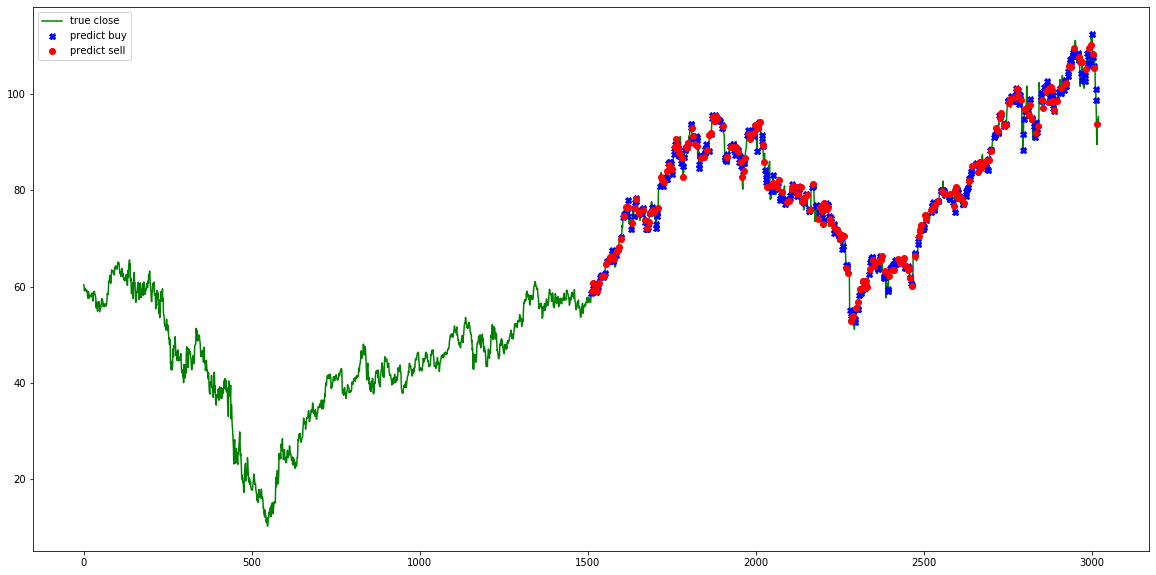

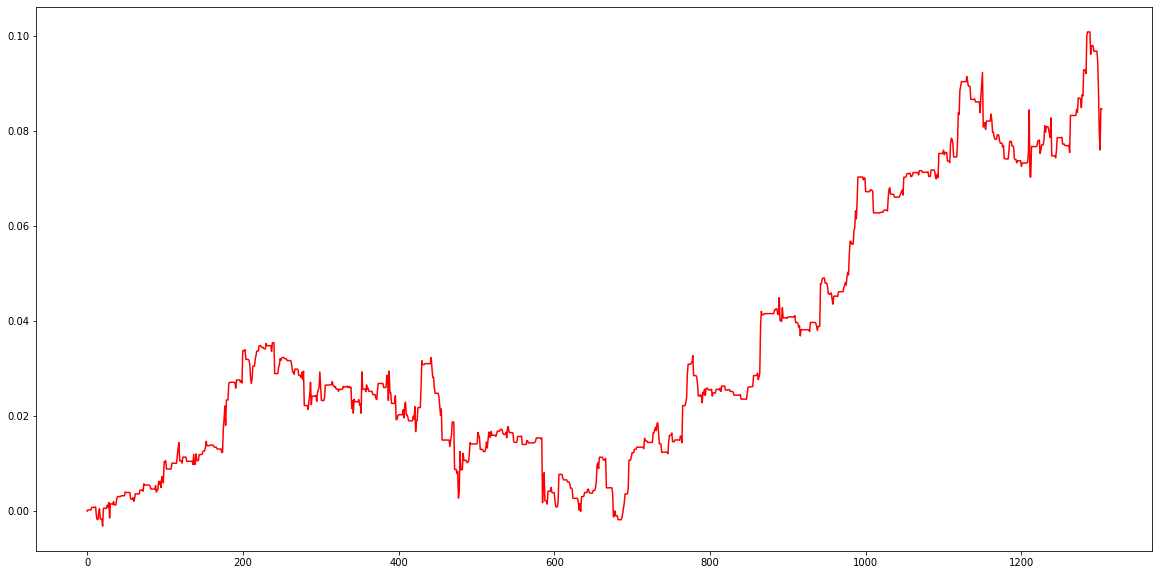

0.6330285318979706
0.6646799584928692
0.5005
0.4754749999999999
0.4754749999999999
iter 10. reward: 0.268662
day 1510: buy 1 units at price 58.750000, total balance 99941.250000
day 1511: buy 1 units at price 59.000000, total balance 99882.250000
day 1512, sell 2 units at price 119.220000, total balance 100001.470000,
day 1518: buy 1 units at price 61.210000, total balance 99940.260000
day 1521: buy 3 units at price 182.220000, total balance 99758.040000
day 1523: buy 3 units at price 178.200000, total balance 99579.840000
day 1524, sell 7 units at price 412.510000, total balance 99992.350000,
day 1526: buy 5 units at price 297.500000, total balance 99694.850000
day 1528: buy 5 units at price 297.250000, total balance 99397.600000
day 1530, sell 10 units at price 588.100000, total balance 99985.700000,
day 1531: buy 3 units at price 179.730000, total balance 99805.970000
day 1533: buy 1 units at price 60.660000, total balance 99745.310000
day 1534: buy 1 units at price 60.560000, total

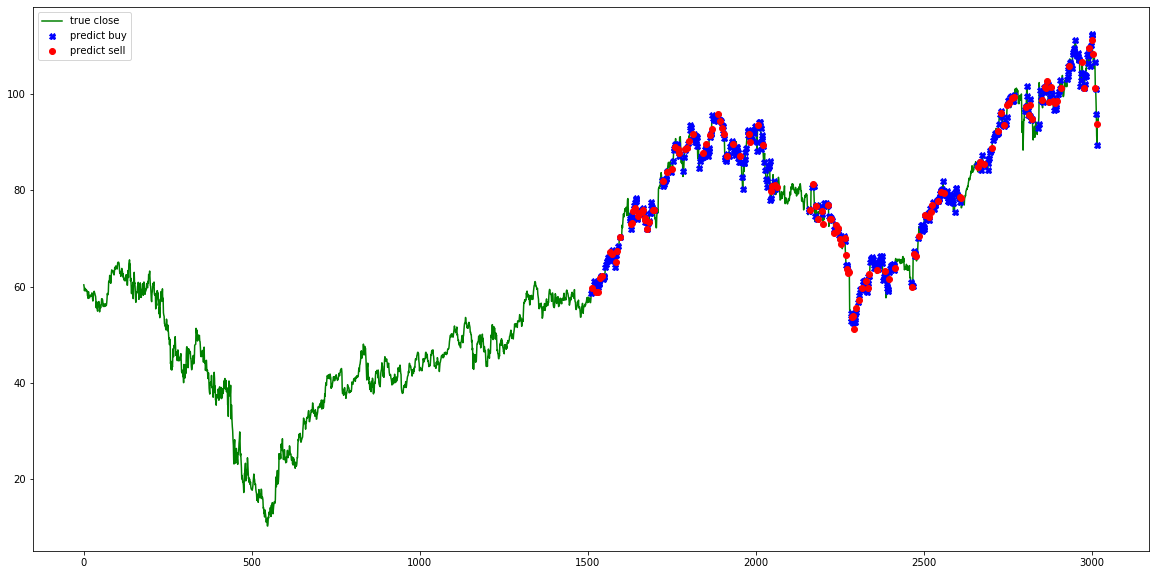

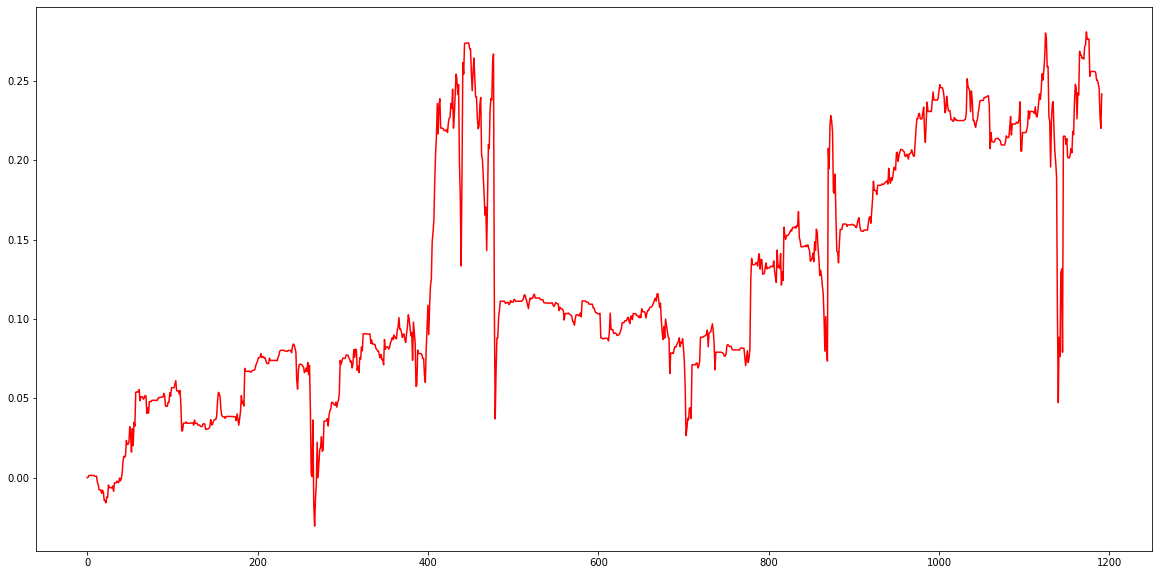

0.4517012499999999
0.42911618749999986
0.42911618749999986
0.4505719968749999
0.4280433970312499
iter 15. reward: 1.494143
day 1510: buy 5 units at price 293.750000, total balance 99706.250000
day 1512: buy 1 units at price 59.610000, total balance 99646.640000
day 1514: buy 7 units at price 421.400000, total balance 99225.240000
day 1515: buy 3 units at price 180.780000, total balance 99044.460000
day 1517, sell 16 units at price 979.840000, total balance 100024.300000,
day 1519: buy 7 units at price 425.320000, total balance 99598.980000
day 1520: buy 4 units at price 242.480000, total balance 99356.500000
day 1523: buy 7 units at price 415.800000, total balance 98940.700000
day 1524, sell 18 units at price 1060.740000, total balance 100001.440000,
day 1525: buy 5 units at price 296.500000, total balance 99704.940000
day 1527: buy 4 units at price 236.280000, total balance 99468.660000
day 1528: buy 12 units at price 713.400000, total balance 98755.260000
day 1530, sell 21 units at p

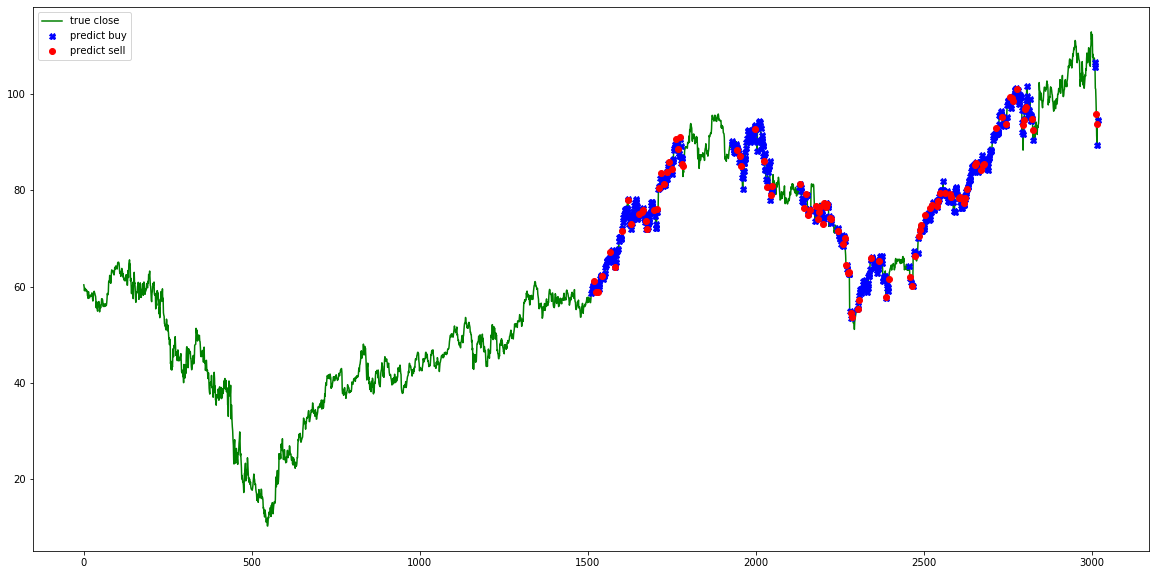

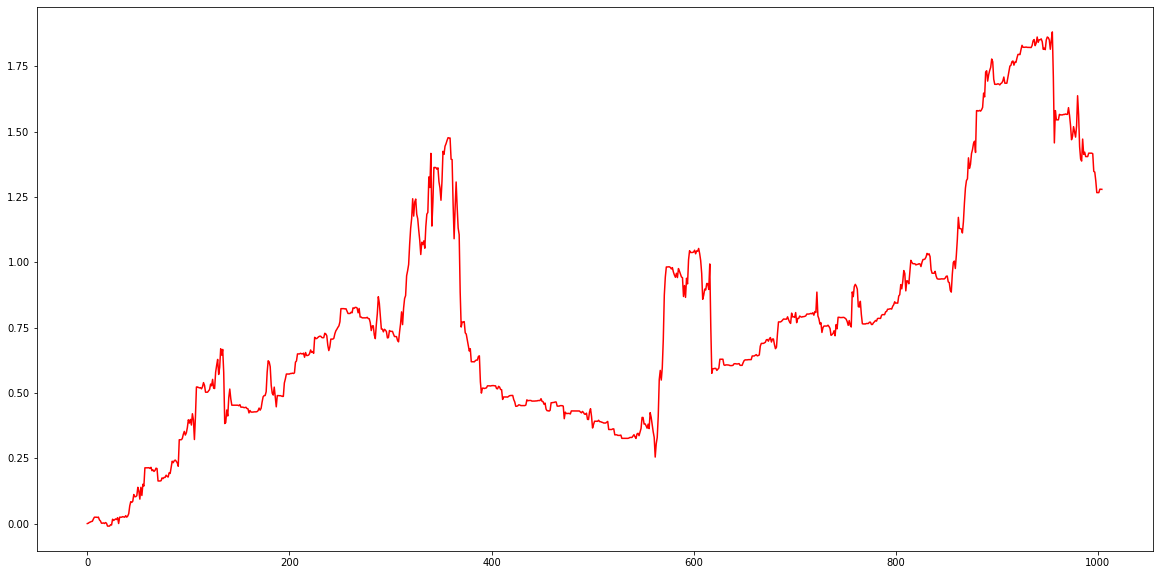

0.4280433970312499
0.40664122717968737
0.4269732885386718
0.4483219529656054
0.4483219529656054
iter 20. reward: 2.518600
day 1510: buy 6 units at price 352.500000, total balance 99647.500000
day 1511: buy 1 units at price 59.000000, total balance 99588.500000
day 1512, sell 7 units at price 417.270000, total balance 100005.770000,
day 1514: buy 12 units at price 722.400000, total balance 99283.370000
day 1515: buy 3 units at price 180.780000, total balance 99102.590000
day 1516: buy 8 units at price 486.320000, total balance 98616.270000
day 1517, sell 23 units at price 1408.520000, total balance 100024.790000,
day 1518: buy 1 units at price 61.210000, total balance 99963.580000
day 1519: buy 7 units at price 425.320000, total balance 99538.260000
day 1520: buy 5 units at price 303.100000, total balance 99235.160000
day 1521: buy 4 units at price 242.960000, total balance 98992.200000
day 1523: buy 8 units at price 475.200000, total balance 98517.000000
day 1524, sell 25 units at pric

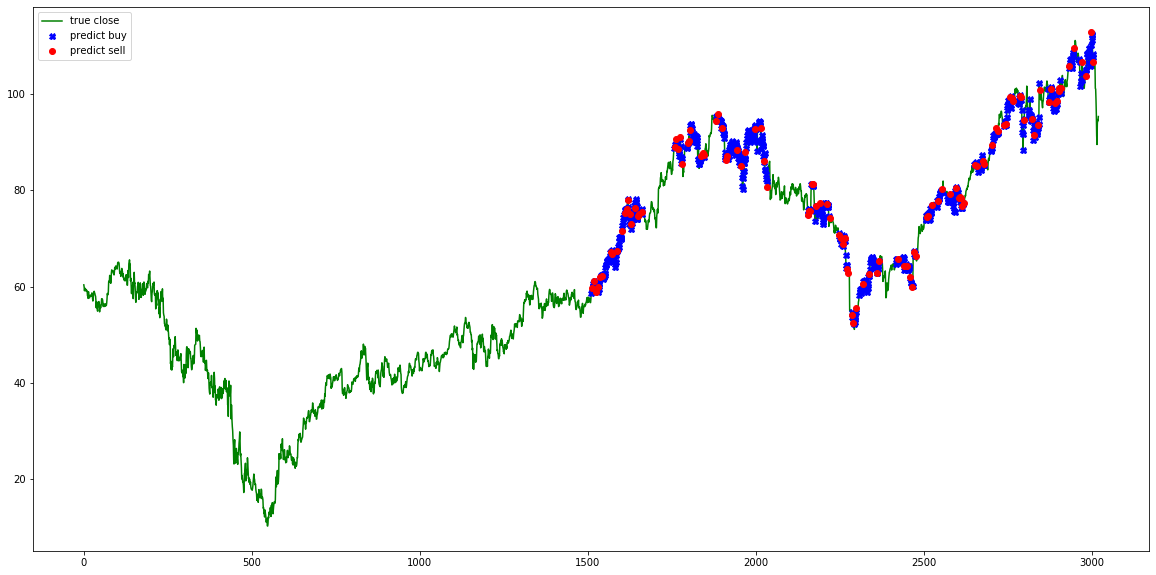

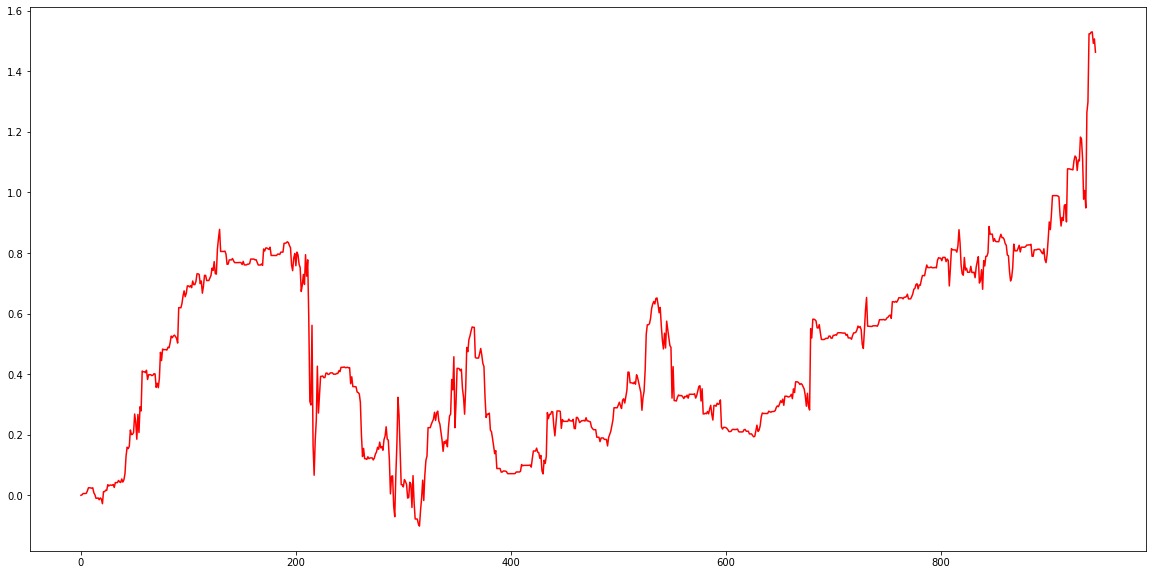

0.4707380506138857
0.4472011480831914
0.4248410906790318
0.4248410906790318
0.4248410906790318
iter 25. reward: 3.613670
day 1510: buy 9 units at price 528.750000, total balance 99471.250000
day 1511: buy 3 units at price 177.000000, total balance 99294.250000
day 1512: buy 7 units at price 417.270000, total balance 98876.980000
day 1513, sell 19 units at price 1137.340000, total balance 100014.320000,
day 1514: buy 18 units at price 1083.600000, total balance 98930.720000
day 1515: buy 4 units at price 241.040000, total balance 98689.680000
day 1516: buy 9 units at price 547.110000, total balance 98142.570000
day 1517: buy 3 units at price 183.720000, total balance 97958.850000
day 1518: buy 1 units at price 61.210000, total balance 97897.640000
day 1519: buy 12 units at price 729.120000, total balance 97168.520000
day 1520: buy 7 units at price 424.340000, total balance 96744.180000
day 1521: buy 11 units at price 668.140000, total balance 96076.040000
day 1522: buy 8 units at price 

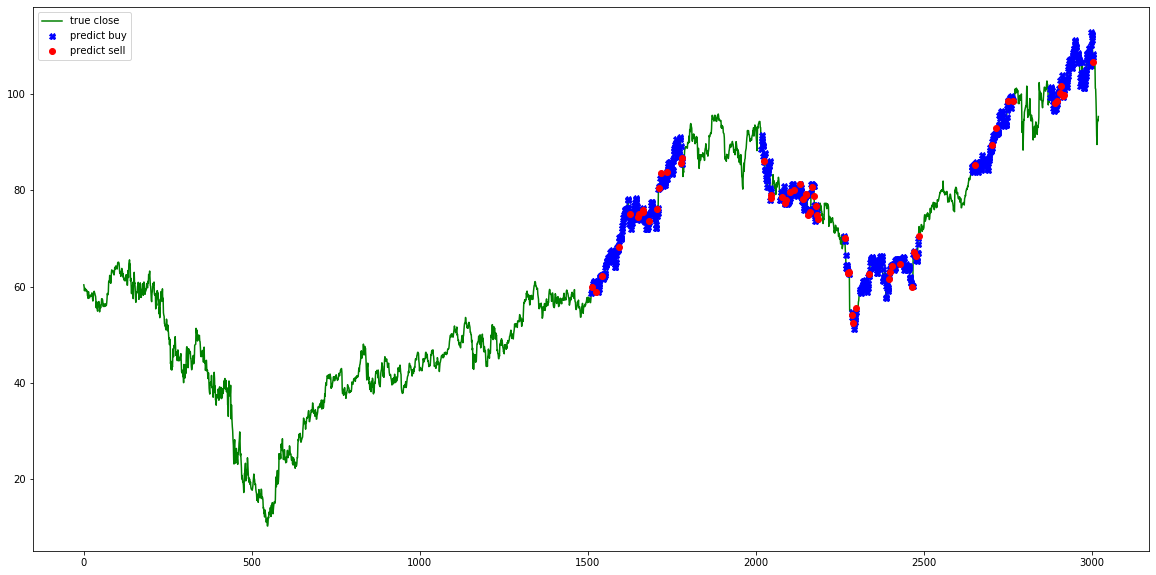

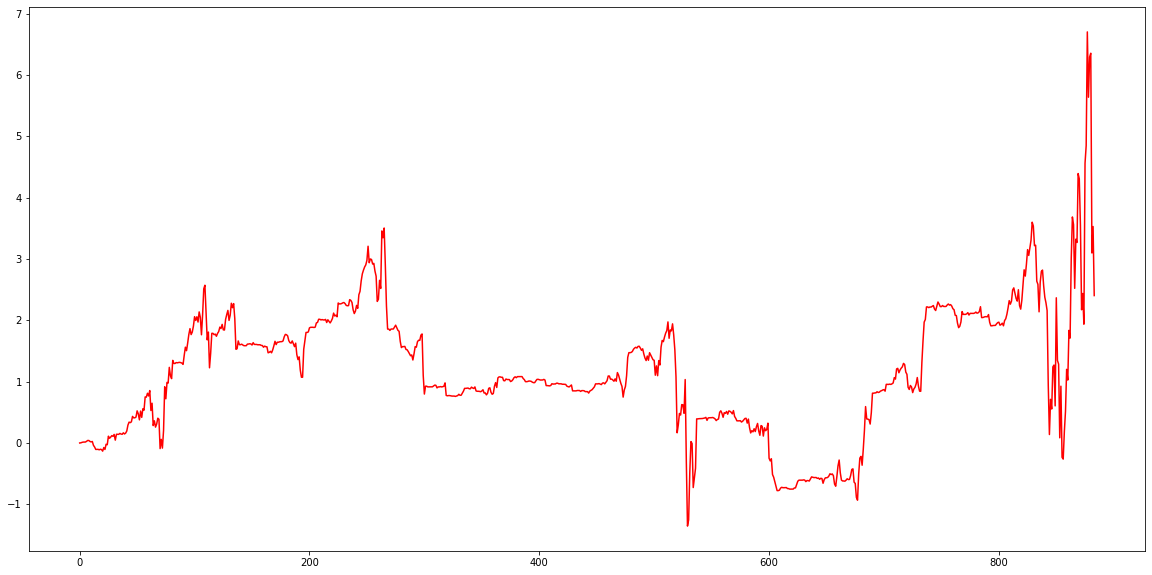

0.4460831452129834
0.4460831452129834
0.5005
0.5005
0.5005
iter 30. reward: -2.941040
day 1510: buy 12 units at price 705.000000, total balance 99295.000000
day 1512: buy 8 units at price 476.880000, total balance 98818.120000
day 1514: buy 17 units at price 1023.400000, total balance 97794.720000
day 1515: buy 4 units at price 241.040000, total balance 97553.680000
day 1516: buy 14 units at price 851.060000, total balance 96702.620000
day 1517: buy 1 units at price 61.240000, total balance 96641.380000
day 1518: buy 1 units at price 61.210000, total balance 96580.170000
day 1519: buy 18 units at price 1093.680000, total balance 95486.490000
day 1520: buy 4 units at price 242.480000, total balance 95244.010000
day 1521: buy 17 units at price 1032.580000, total balance 94211.430000
day 1523: buy 8 units at price 475.200000, total balance 93736.230000
day 1524, sell 104 units at price 6128.720000, total balance 99864.950000,
day 1525: buy 4 units at price 237.200000, total balance 99627.

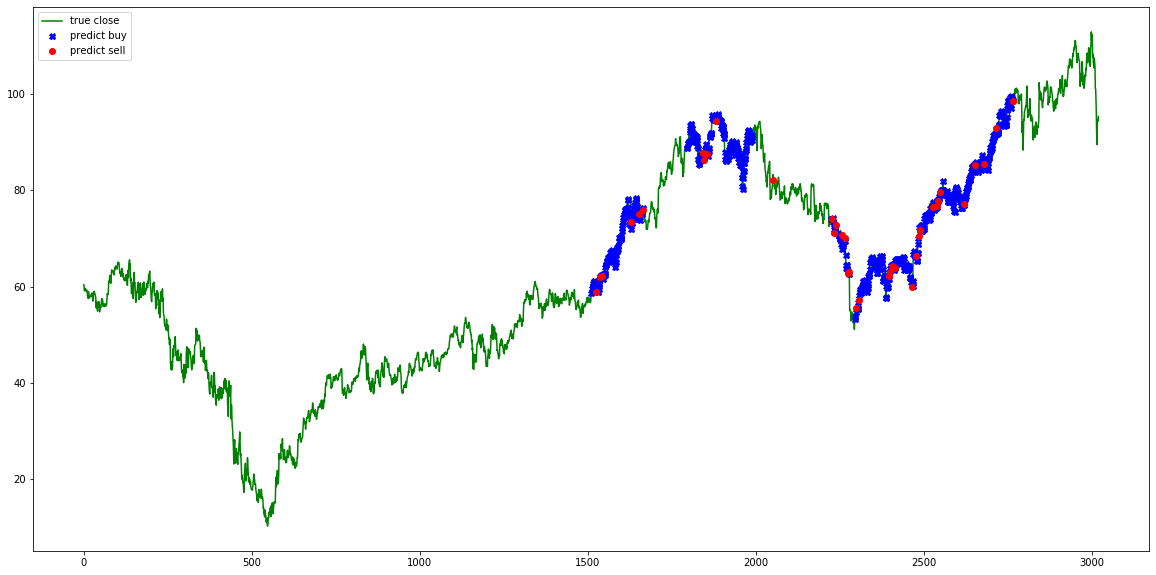

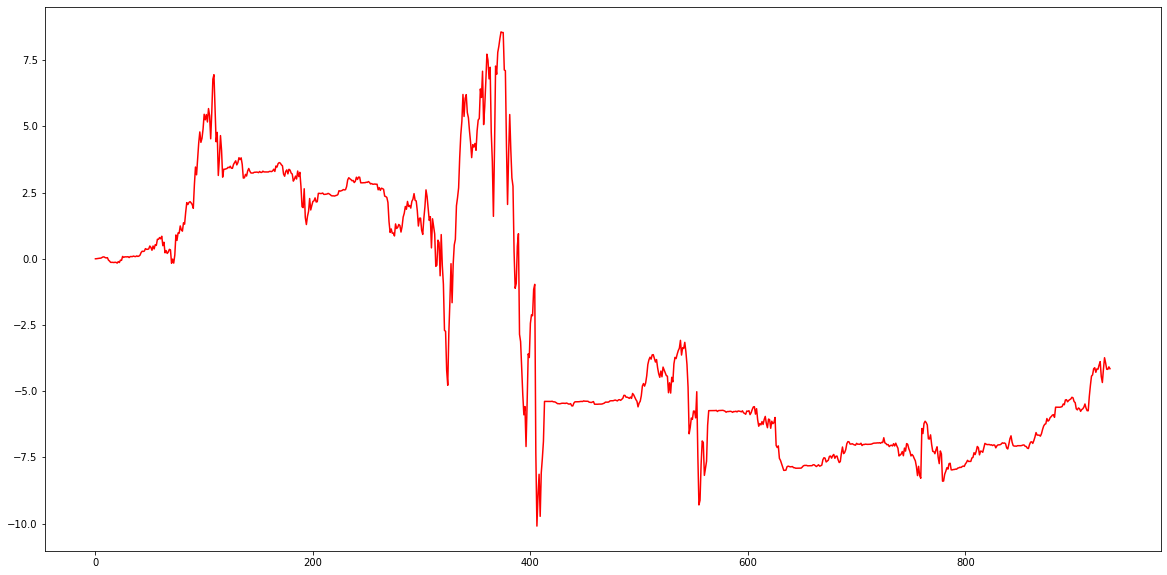

0.5005
0.5005
0.5005
0.5005
0.525525
iter 35. reward: 0.626690
day 1510: buy 10 units at price 587.500000, total balance 99412.500000
day 1512: buy 5 units at price 298.050000, total balance 99114.450000
day 1513, sell 15 units at price 897.900000, total balance 100012.350000,
day 1514: buy 23 units at price 1384.600000, total balance 98627.750000
day 1515: buy 1 units at price 60.260000, total balance 98567.490000
day 1516: buy 15 units at price 911.850000, total balance 97655.640000
day 1517: buy 1 units at price 61.240000, total balance 97594.400000
day 1518: buy 2 units at price 122.420000, total balance 97471.980000
day 1519: buy 13 units at price 789.880000, total balance 96682.100000
day 1520: buy 2 units at price 121.240000, total balance 96560.860000
day 1521: buy 22 units at price 1336.280000, total balance 95224.580000
day 1523: buy 9 units at price 534.600000, total balance 94689.980000
day 1524, sell 88 units at price 5185.840000, total balance 99875.820000,
day 1536: buy 

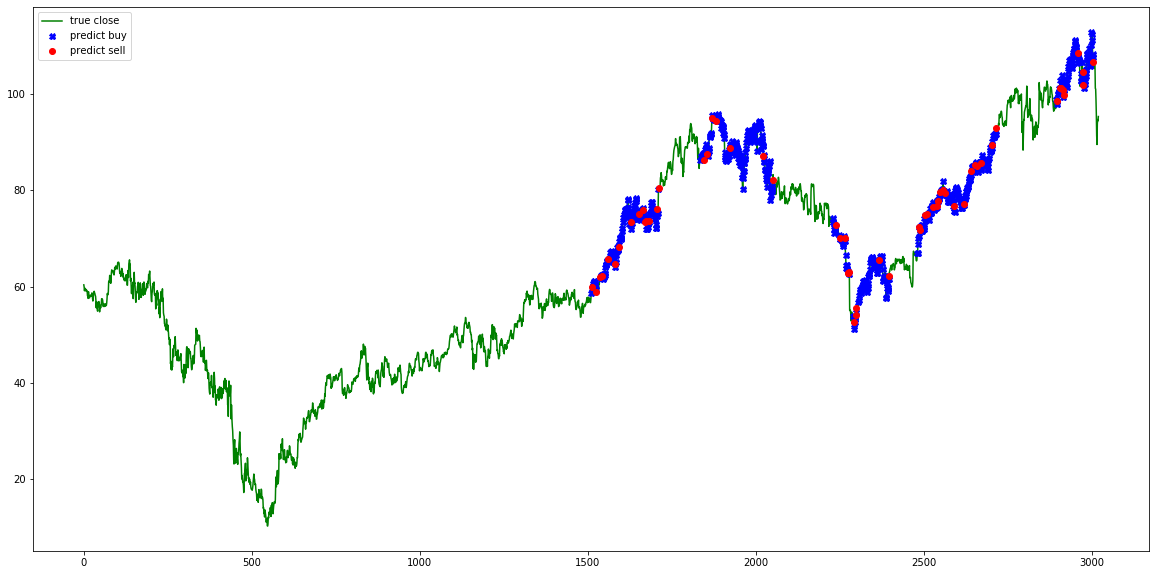

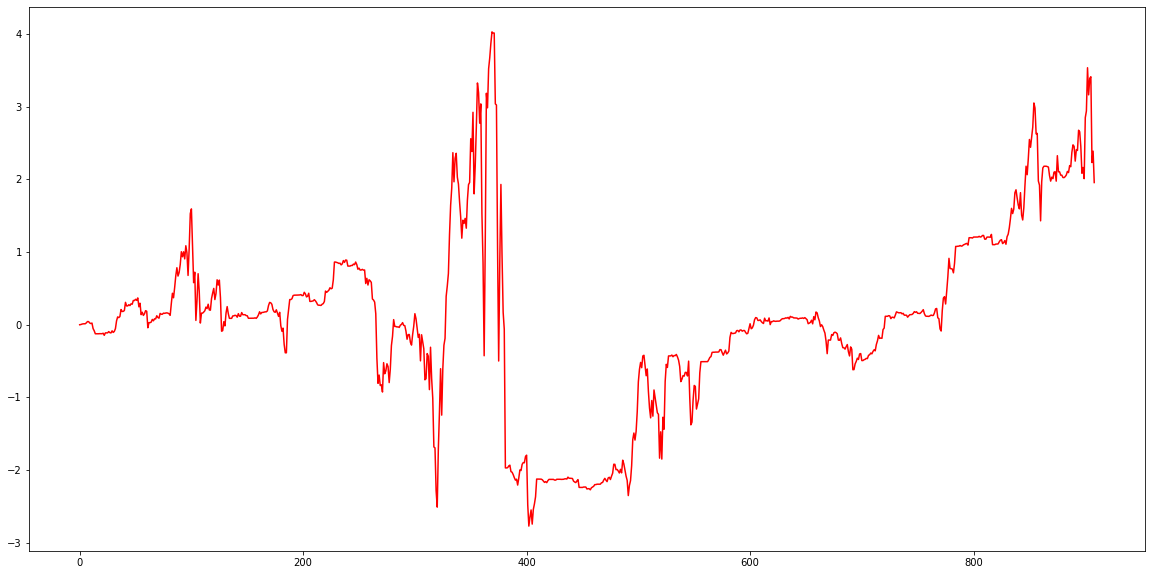

0.5005
0.5005
0.5005
0.5005
0.5005
iter 40. reward: -4.660520
day 1510: buy 10 units at price 587.500000, total balance 99412.500000
day 1512: buy 1 units at price 59.610000, total balance 99352.890000
day 1513, sell 11 units at price 658.460000, total balance 100011.350000,
day 1514: buy 24 units at price 1444.800000, total balance 98566.550000
day 1515: buy 1 units at price 60.260000, total balance 98506.290000
day 1516: buy 9 units at price 547.110000, total balance 97959.180000
day 1517: buy 1 units at price 61.240000, total balance 97897.940000
day 1518: buy 2 units at price 122.420000, total balance 97775.520000
day 1519: buy 5 units at price 303.800000, total balance 97471.720000
day 1520: buy 10 units at price 606.200000, total balance 96865.520000
day 1521: buy 10 units at price 607.400000, total balance 96258.120000
day 1523: buy 12 units at price 712.800000, total balance 95545.320000
day 1524, sell 74 units at price 4360.820000, total balance 99906.140000,
day 1535: buy 10 

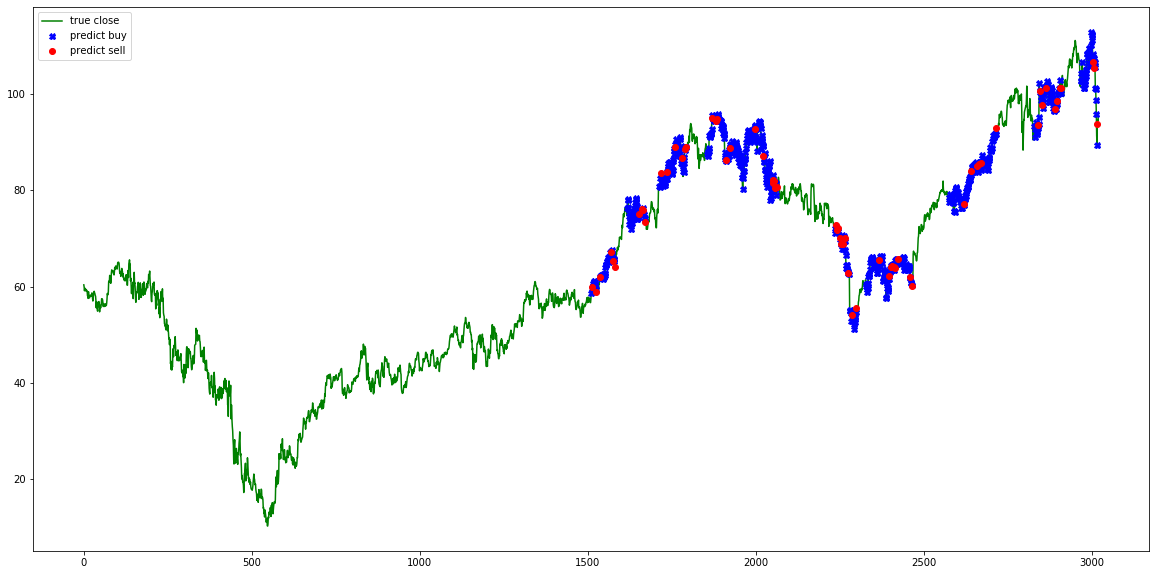

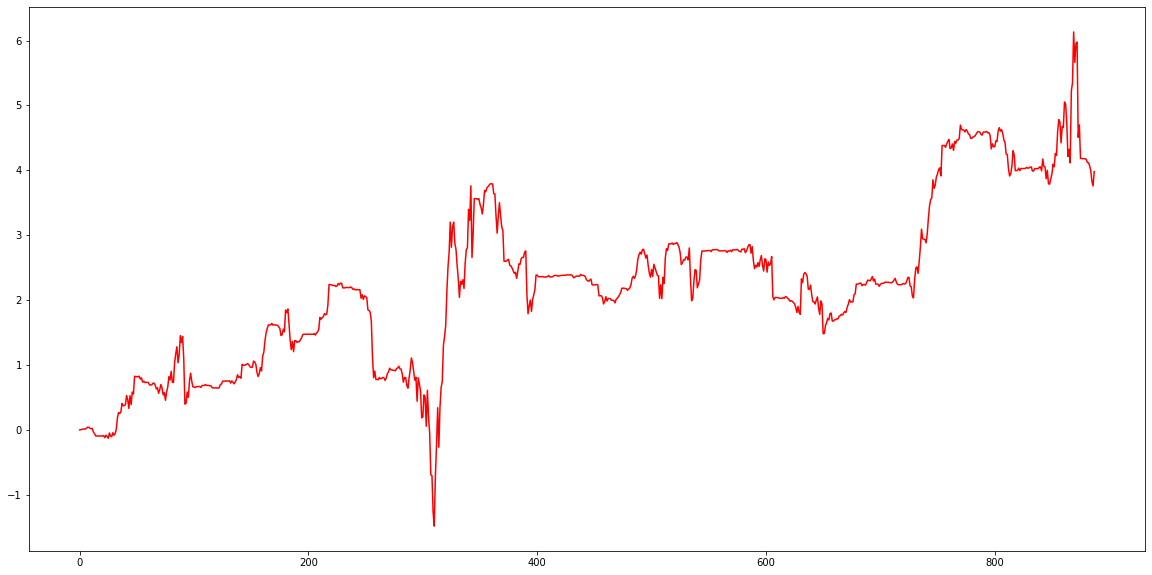

0.5005
0.5005
0.5005
0.5005
0.5005
iter 45. reward: 2.047260
day 1510: buy 12 units at price 705.000000, total balance 99295.000000
day 1512: buy 2 units at price 119.220000, total balance 99175.780000
day 1514: buy 28 units at price 1685.600000, total balance 97490.180000
day 1515: buy 1 units at price 60.260000, total balance 97429.920000
day 1516: buy 9 units at price 547.110000, total balance 96882.810000
day 1517: buy 5 units at price 306.200000, total balance 96576.610000
day 1518: buy 4 units at price 244.840000, total balance 96331.770000
day 1519: buy 7 units at price 425.320000, total balance 95906.450000
day 1521: buy 8 units at price 485.920000, total balance 95420.530000
day 1523: buy 8 units at price 475.200000, total balance 94945.330000
day 1524: buy 9 units at price 530.370000, total balance 94414.960000
day 1525, sell 93 units at price 5514.900000, total balance 99929.860000,
day 1526: buy 12 units at price 714.000000, total balance 99215.860000
day 1528: buy 20 units

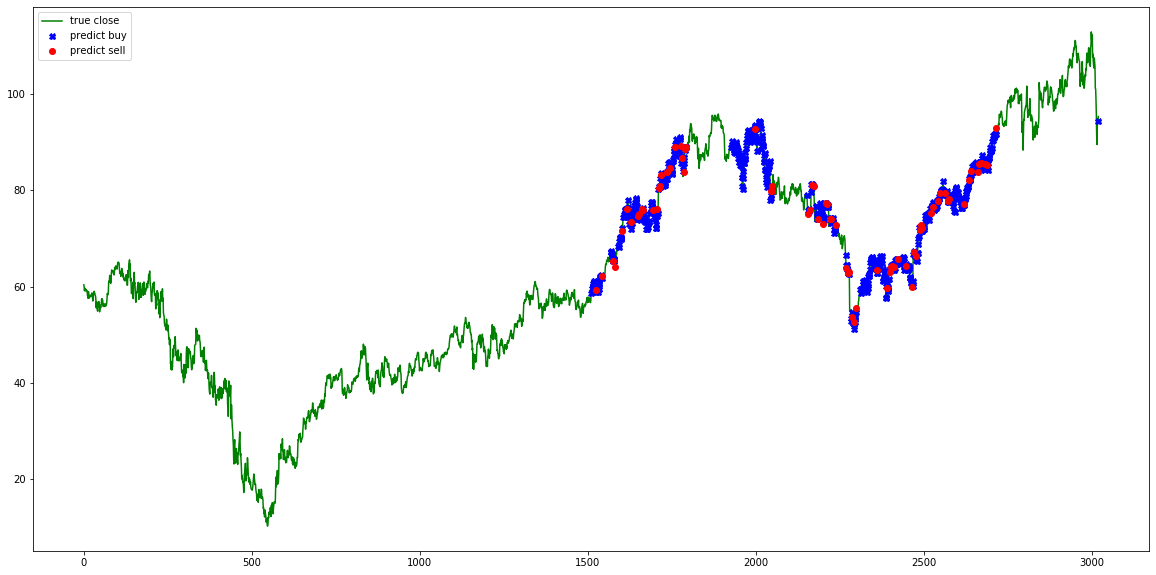

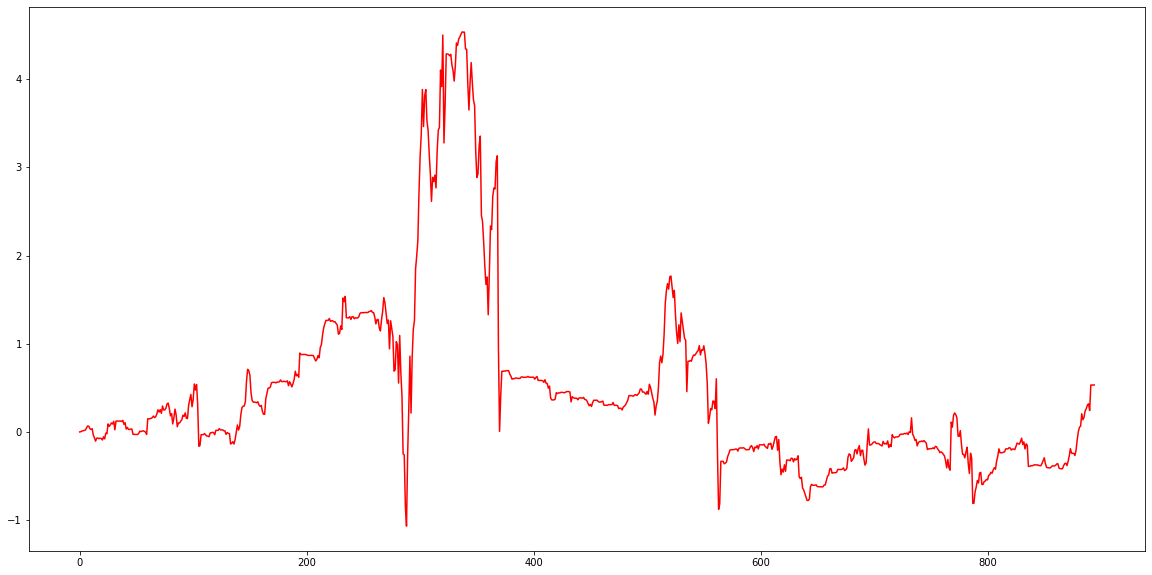

0.525525
0.525525
0.525525
0.525525
0.525525
iter 50. reward: 1.019200
day 1510: buy 14 units at price 822.500000, total balance 99177.500000
day 1512: buy 9 units at price 536.490000, total balance 98641.010000
day 1514: buy 34 units at price 2046.800000, total balance 96594.210000
day 1515: buy 1 units at price 60.260000, total balance 96533.950000
day 1516: buy 8 units at price 486.320000, total balance 96047.630000
day 1518: buy 1 units at price 61.210000, total balance 95986.420000
day 1519: buy 10 units at price 607.600000, total balance 95378.820000
day 1521: buy 3 units at price 182.220000, total balance 95196.600000
day 1523: buy 6 units at price 356.400000, total balance 94840.200000
day 1524, sell 86 units at price 5067.980000, total balance 99908.180000,
day 1536: buy 15 units at price 927.000000, total balance 98981.180000
day 1537, sell 15 units at price 929.700000, total balance 99910.880000,
day 1538: buy 26 units at price 1617.200000, total balance 98293.680000
day 153

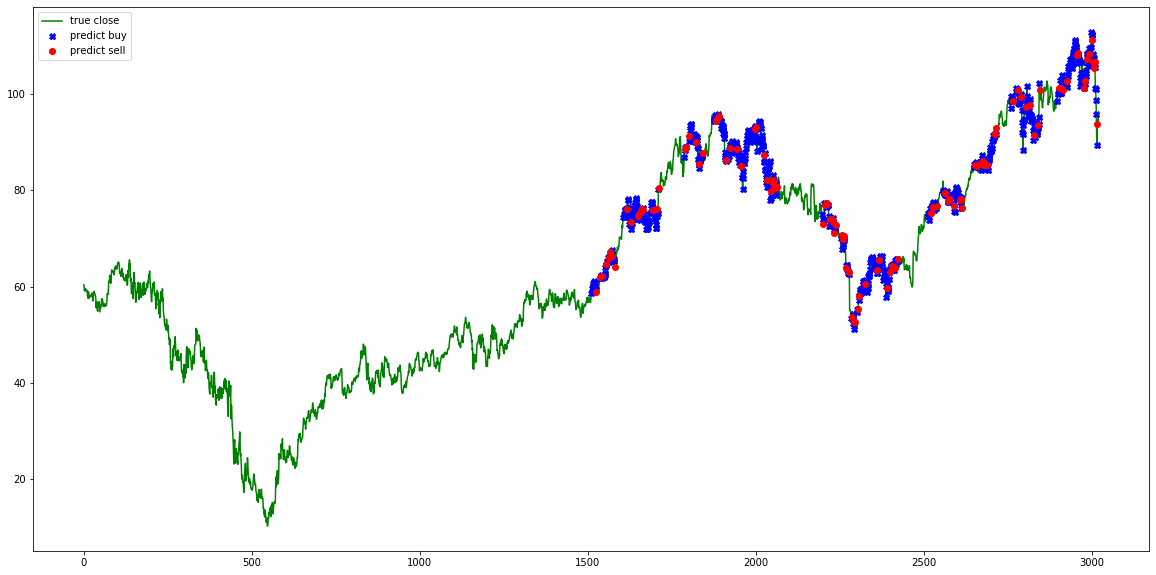

0.525525
0.55180125
0.55180125
0.5793913125000001
0.5005
iter 55. reward: -0.406880
day 1510: buy 16 units at price 940.000000, total balance 99060.000000
day 1512: buy 6 units at price 357.660000, total balance 98702.340000
day 1514: buy 38 units at price 2287.600000, total balance 96414.740000
day 1515: buy 6 units at price 361.560000, total balance 96053.180000
day 1516: buy 2 units at price 121.580000, total balance 95931.600000
day 1518: buy 7 units at price 428.470000, total balance 95503.130000
day 1519: buy 4 units at price 243.040000, total balance 95260.090000
day 1521: buy 6 units at price 364.440000, total balance 94895.650000
day 1523: buy 6 units at price 356.400000, total balance 94539.250000
day 1524: buy 7 units at price 412.510000, total balance 94126.740000
day 1525, sell 98 units at price 5811.400000, total balance 99938.140000,
day 1526: buy 11 units at price 654.500000, total balance 99283.640000
day 1528: buy 18 units at price 1070.100000, total balance 98213.540

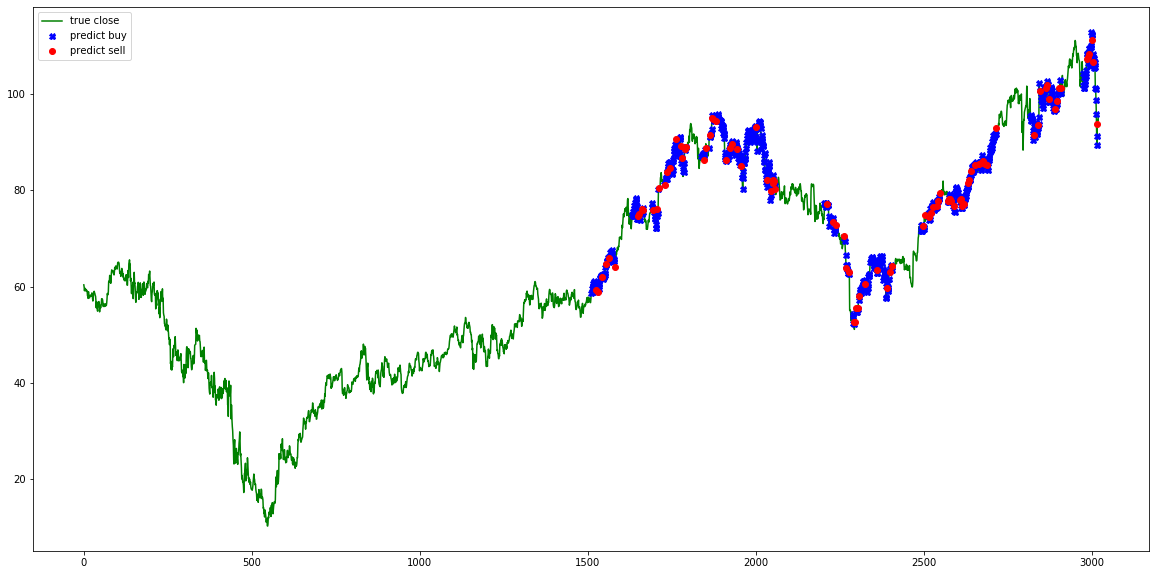

0.5005
0.5005
0.5005
0.5005
0.4754749999999999
iter 60. reward: 5.580170
day 1510: buy 20 units at price 1175.000000, total balance 98825.000000
day 1511: buy 1 units at price 59.000000, total balance 98766.000000
day 1512, sell 21 units at price 1251.810000, total balance 100017.810000,
day 1514: buy 36 units at price 2167.200000, total balance 97850.610000
day 1515: buy 7 units at price 421.820000, total balance 97428.790000
day 1516: buy 6 units at price 364.740000, total balance 97064.050000
day 1517: buy 18 units at price 1102.320000, total balance 95961.730000
day 1518: buy 7 units at price 428.470000, total balance 95533.260000
day 1519: buy 3 units at price 182.280000, total balance 95350.980000
day 1521: buy 8 units at price 485.920000, total balance 94865.060000
day 1522: buy 8 units at price 478.240000, total balance 94386.820000
day 1523: buy 9 units at price 534.600000, total balance 93852.220000
day 1524: buy 10 units at price 589.300000, total balance 93262.920000
day 15

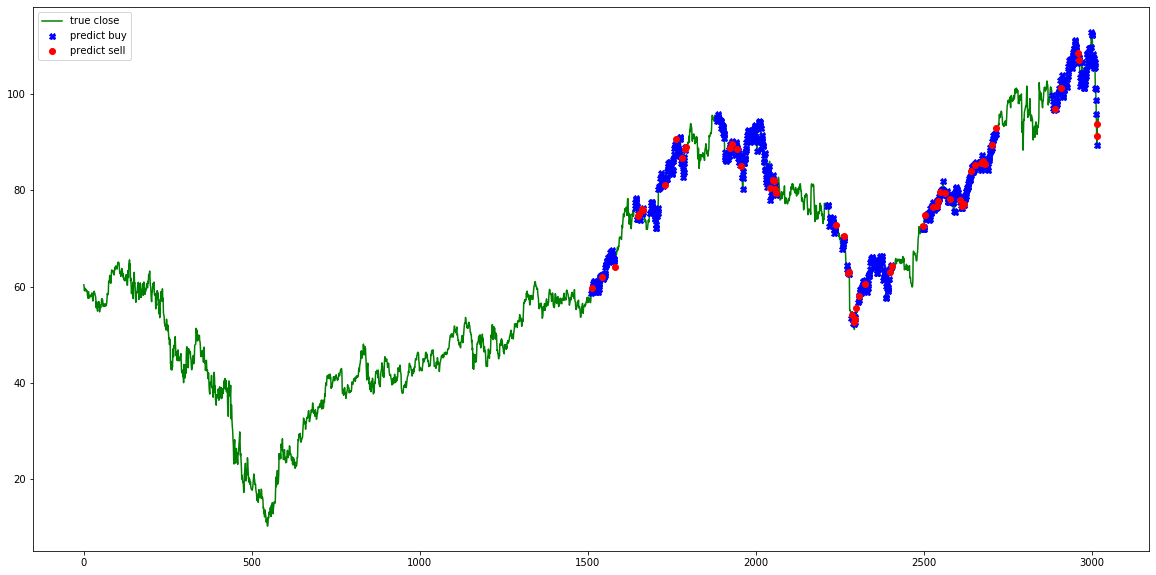

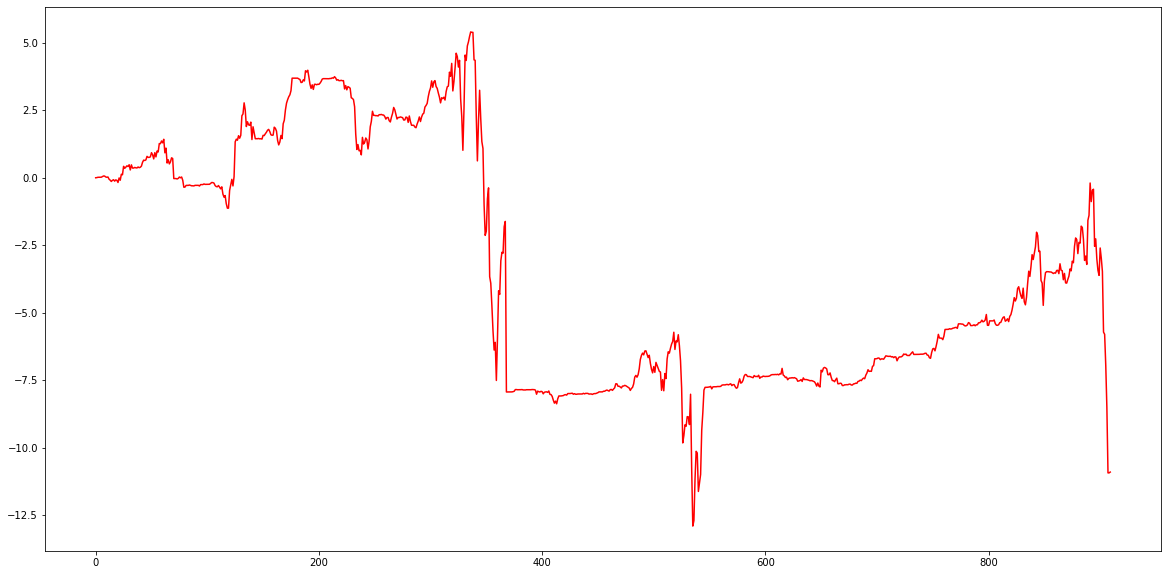

0.4754749999999999
0.4754749999999999
0.4517012499999999
0.4517012499999999
0.42911618749999986
iter 65. reward: 12.521940
day 1510: buy 27 units at price 1586.250000, total balance 98413.750000
day 1511: buy 1 units at price 59.000000, total balance 98354.750000
day 1512, sell 28 units at price 1669.080000, total balance 100023.830000,
day 1514: buy 31 units at price 1866.200000, total balance 98157.630000
day 1515: buy 10 units at price 602.600000, total balance 97555.030000
day 1516: buy 9 units at price 547.110000, total balance 97007.920000
day 1518: buy 9 units at price 550.890000, total balance 96457.030000
day 1519: buy 11 units at price 668.360000, total balance 95788.670000
day 1521: buy 6 units at price 364.440000, total balance 95424.230000
day 1522, sell 76 units at price 4543.280000, total balance 99967.510000,
day 1523: buy 15 units at price 891.000000, total balance 99076.510000
day 1524: buy 13 units at price 766.090000, total balance 98310.420000
day 1526: buy 10 unit

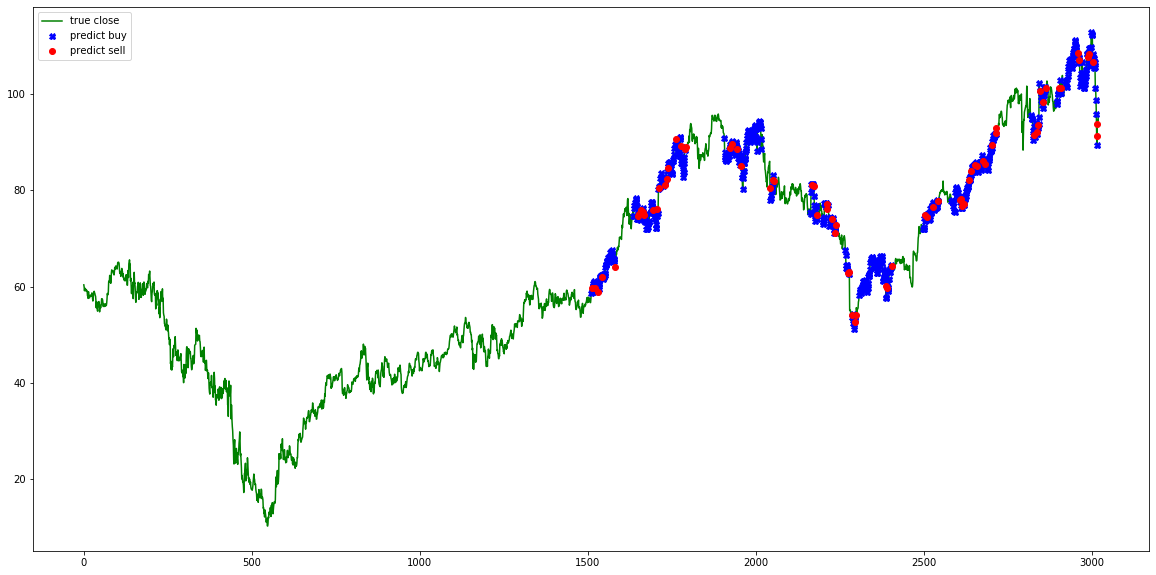

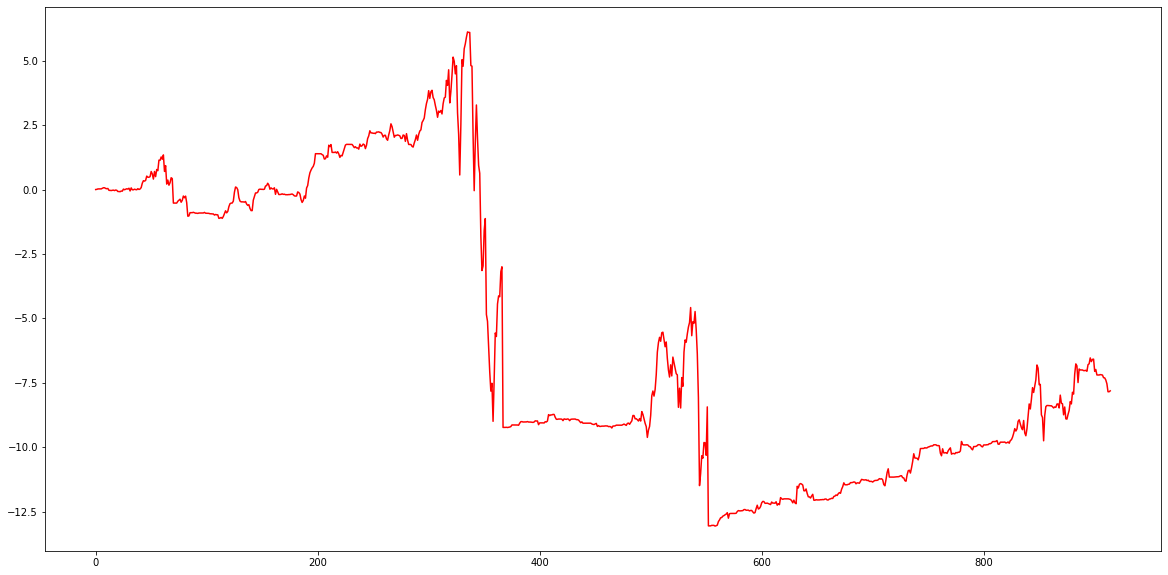

0.42911618749999986
0.42911618749999986
0.40766037812499983
0.40766037812499983
0.40766037812499983
iter 70. reward: 2.805240
day 1510: buy 33 units at price 1938.750000, total balance 98061.250000
day 1511: buy 1 units at price 59.000000, total balance 98002.250000
day 1514: buy 32 units at price 1926.400000, total balance 96075.850000
day 1515: buy 14 units at price 843.640000, total balance 95232.210000
day 1516: buy 9 units at price 547.110000, total balance 94685.100000
day 1517: buy 26 units at price 1592.240000, total balance 93092.860000
day 1518: buy 12 units at price 734.520000, total balance 92358.340000
day 1519: buy 10 units at price 607.600000, total balance 91750.740000
day 1521: buy 11 units at price 668.140000, total balance 91082.600000
day 1523: buy 16 units at price 950.400000, total balance 90132.200000
day 1524: buy 19 units at price 1119.670000, total balance 89012.530000
day 1525, sell 183 units at price 10851.900000, total balance 99864.430000,
day 1526: buy 19

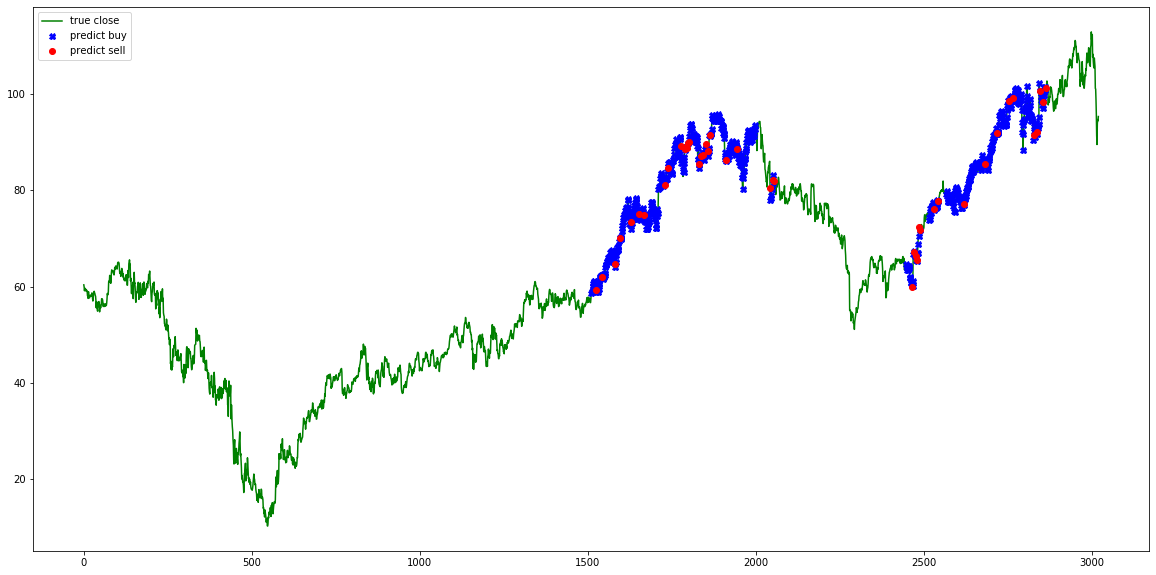

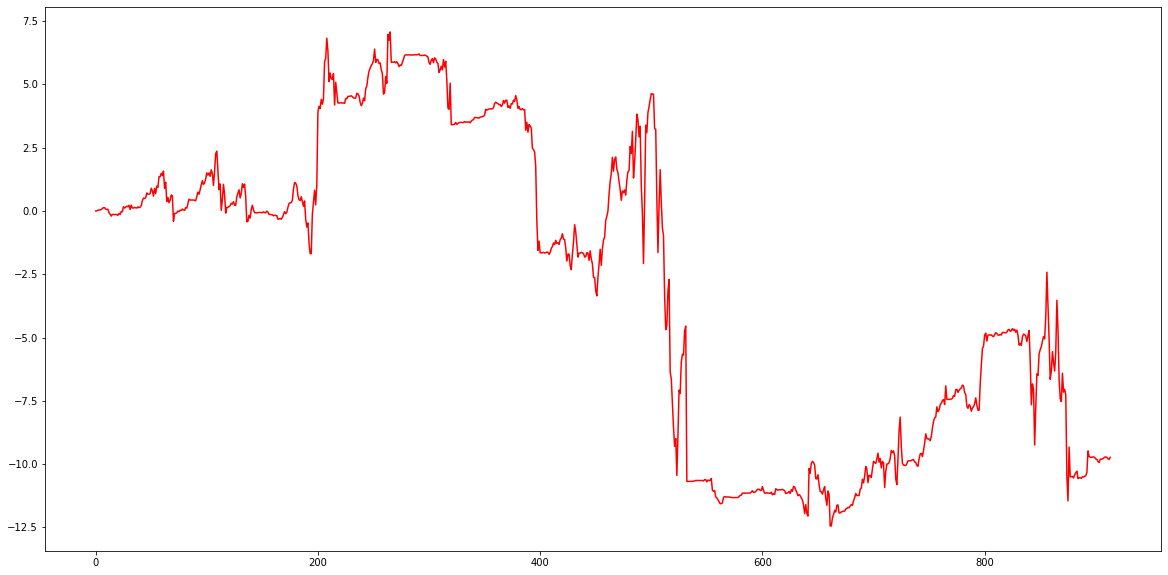

0.40766037812499983
0.40766037812499983
0.38727735921874984
0.3679134912578123
0.3679134912578123
iter 75. reward: 27.983698
day 1510: buy 41 units at price 2408.750000, total balance 97591.250000
day 1511: buy 1 units at price 59.000000, total balance 97532.250000
day 1514: buy 37 units at price 2227.400000, total balance 95304.850000
day 1515: buy 27 units at price 1627.020000, total balance 93677.830000
day 1516: buy 12 units at price 729.480000, total balance 92948.350000
day 1517: buy 31 units at price 1898.440000, total balance 91049.910000
day 1518: buy 19 units at price 1162.990000, total balance 89886.920000
day 1519: buy 21 units at price 1275.960000, total balance 88610.960000
day 1521: buy 16 units at price 971.840000, total balance 87639.120000
day 1523: buy 22 units at price 1306.800000, total balance 86332.320000
day 1524: buy 18 units at price 1060.740000, total balance 85271.580000
day 1525, sell 245 units at price 14528.500000, total balance 99800.080000,
day 1526: bu

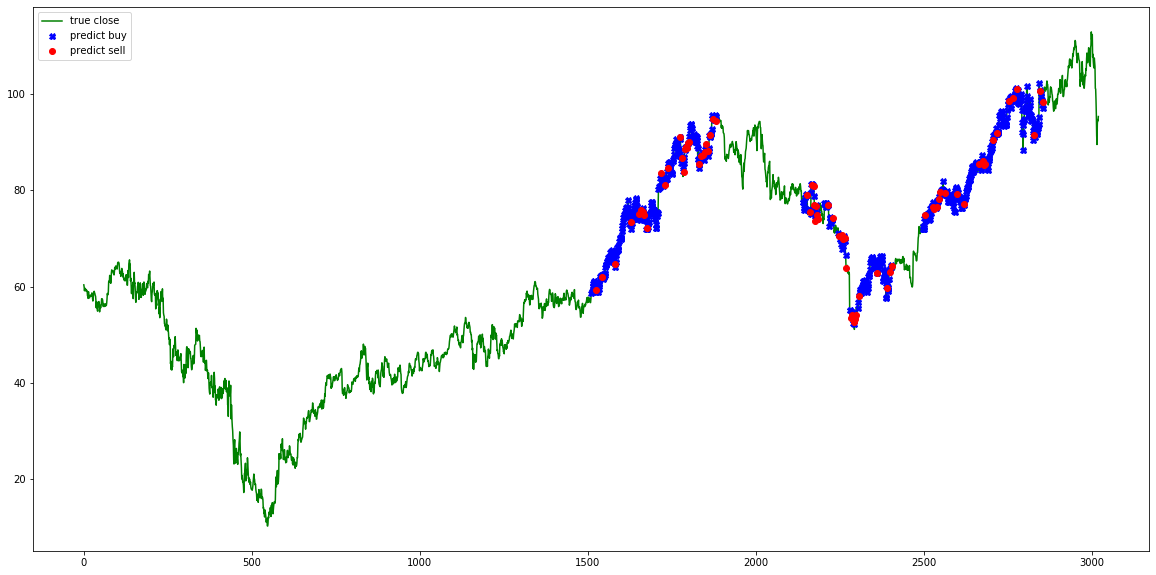

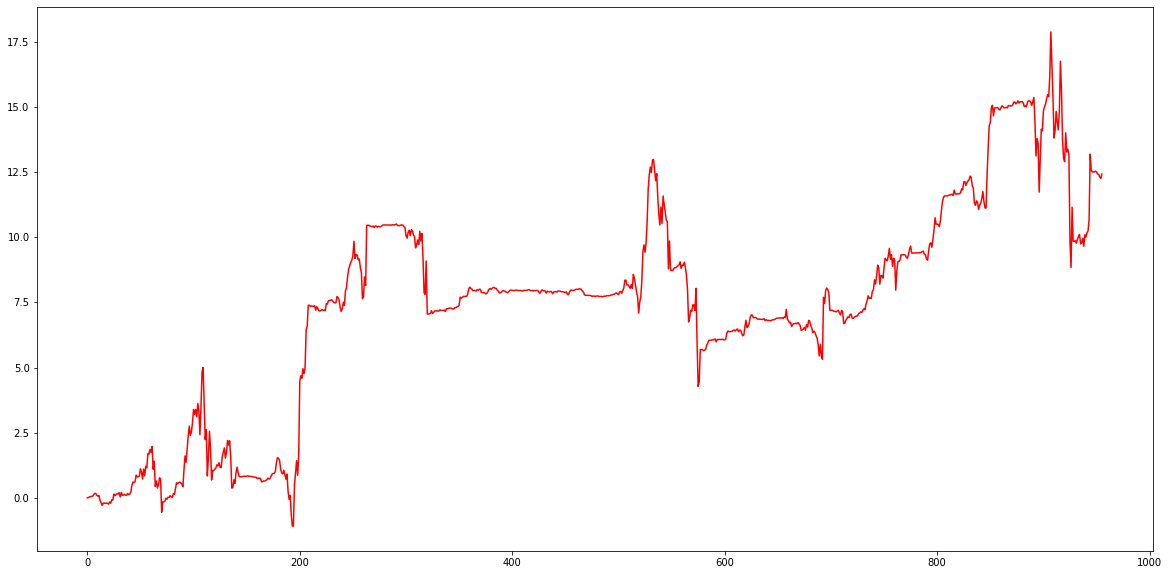

0.3679134912578123
0.3679134912578123
0.3679134912578123
0.3679134912578123
0.3679134912578123
iter 80. reward: 21.752460
day 1510: buy 45 units at price 2643.750000, total balance 97356.250000
day 1511: buy 1 units at price 59.000000, total balance 97297.250000
day 1514: buy 40 units at price 2408.000000, total balance 94889.250000
day 1515: buy 33 units at price 1988.580000, total balance 92900.670000
day 1516: buy 10 units at price 607.900000, total balance 92292.770000
day 1518: buy 23 units at price 1407.830000, total balance 90884.940000
day 1519: buy 20 units at price 1215.200000, total balance 89669.740000
day 1521: buy 21 units at price 1275.540000, total balance 88394.200000
day 1523: buy 26 units at price 1544.400000, total balance 86849.800000
day 1524: buy 23 units at price 1355.390000, total balance 85494.410000
day 1526: buy 27 units at price 1606.500000, total balance 83887.910000
day 1527: buy 27 units at price 1594.890000, total balance 82293.020000
day 1528: buy 33 u

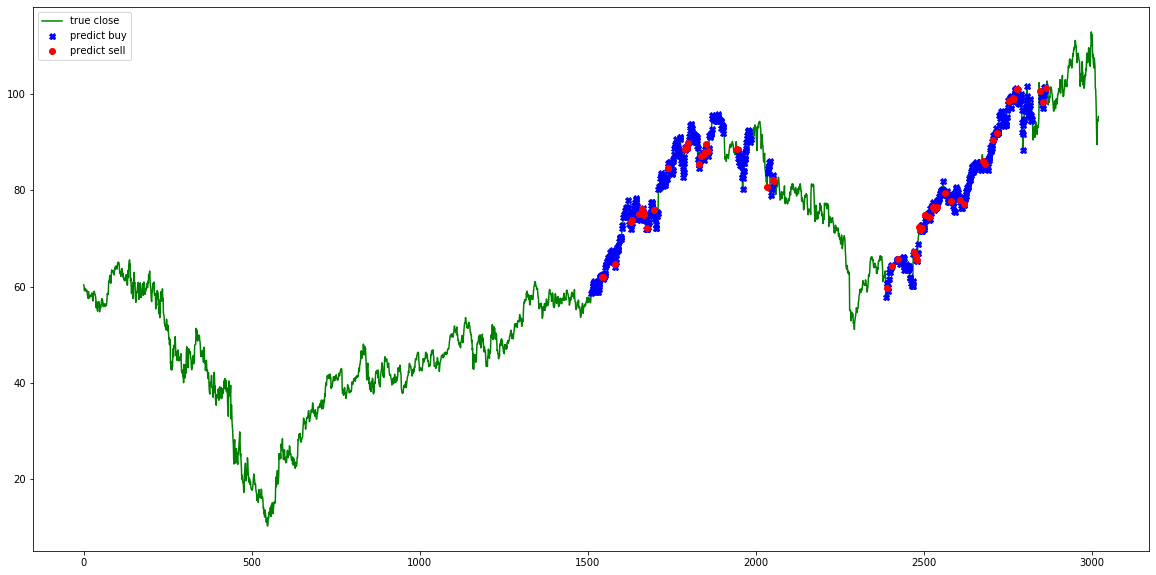

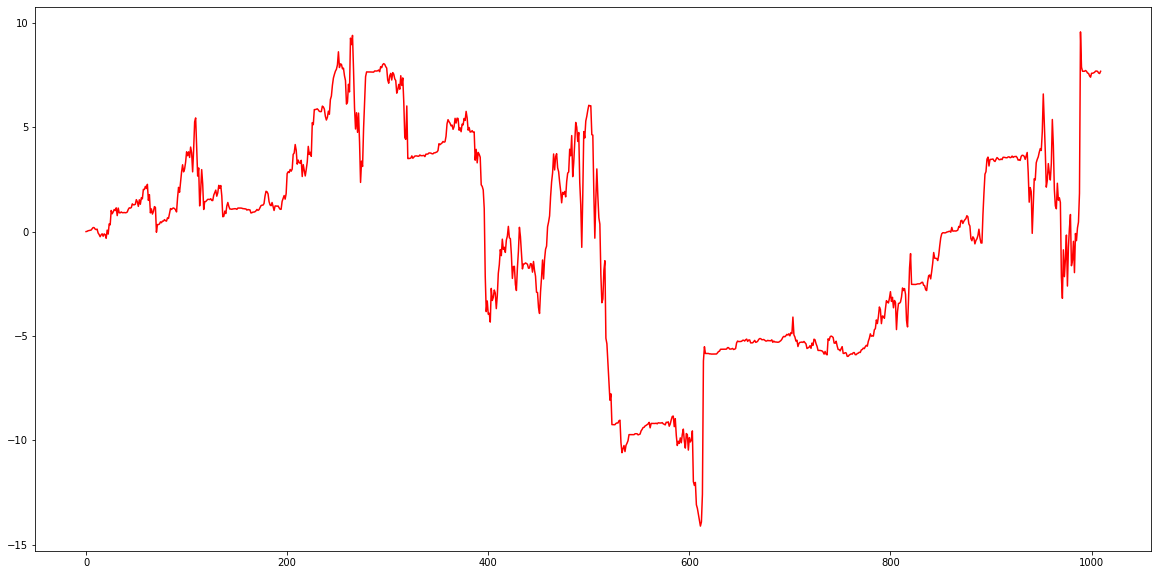

0.3679134912578123
0.34951781669492166
0.34951781669492166
0.34951781669492166
0.34951781669492166
iter 85. reward: 23.670780
day 1510: buy 46 units at price 2702.500000, total balance 97297.500000
day 1511: buy 1 units at price 59.000000, total balance 97238.500000
day 1514: buy 37 units at price 2227.400000, total balance 95011.100000
day 1515: buy 28 units at price 1687.280000, total balance 93323.820000
day 1516: buy 10 units at price 607.900000, total balance 92715.920000
day 1518, sell 122 units at price 7467.620000, total balance 100183.540000,
day 1519: buy 24 units at price 1458.240000, total balance 98725.300000
day 1521: buy 14 units at price 850.360000, total balance 97874.940000
day 1523: buy 24 units at price 1425.600000, total balance 96449.340000
day 1524: buy 26 units at price 1532.180000, total balance 94917.160000
day 1525, sell 88 units at price 5218.400000, total balance 100135.560000,
day 1526: buy 28 units at price 1666.000000, total balance 98469.560000
day 1527

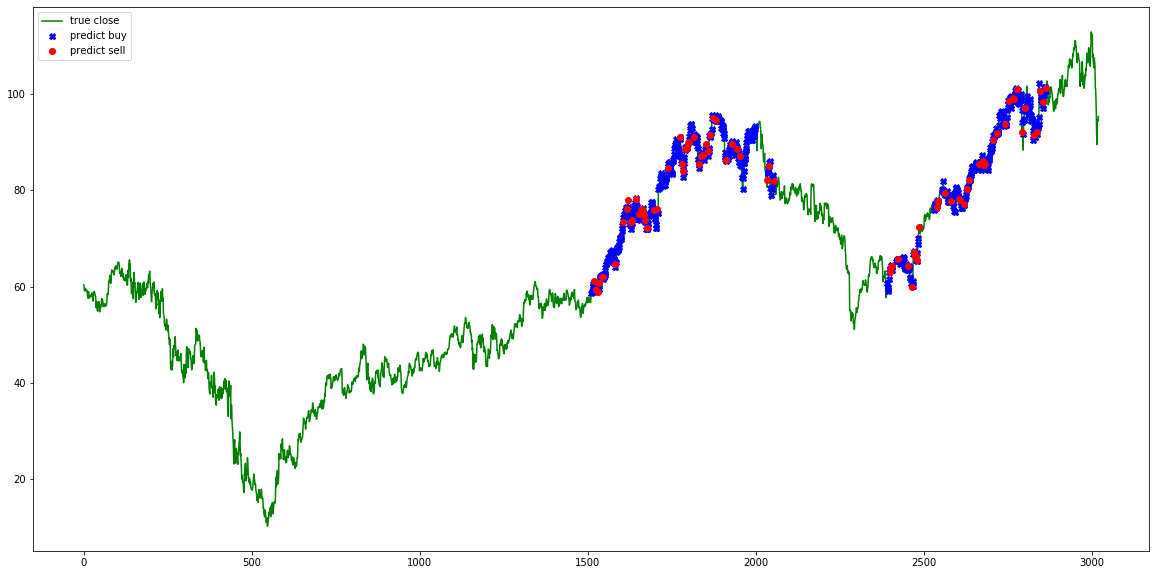

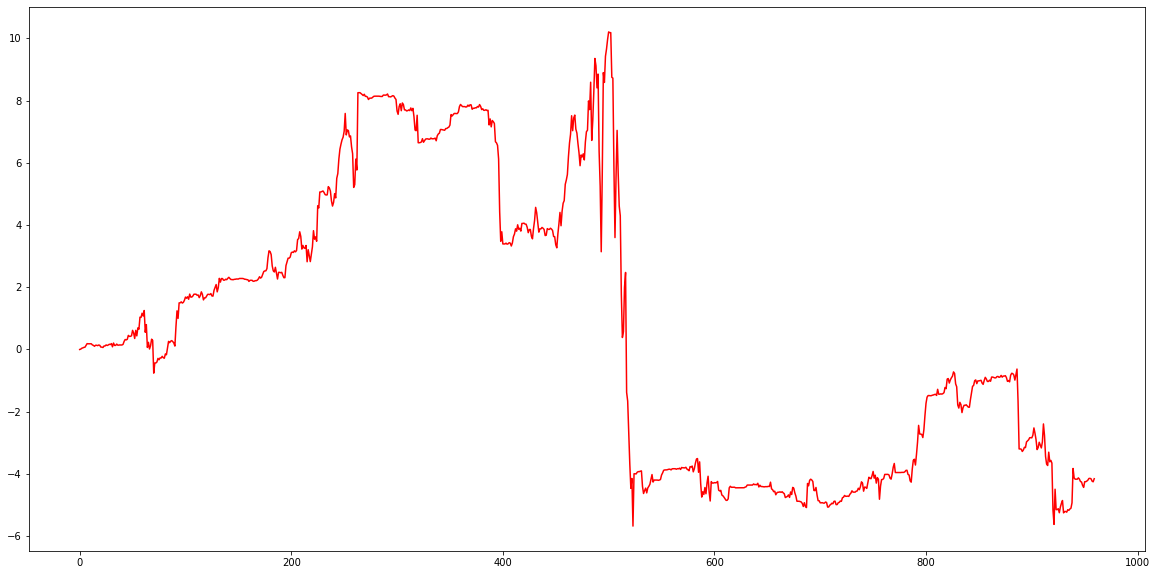

0.34951781669492166
0.34951781669492166
0.34951781669492166
0.34951781669492166
0.34951781669492166
iter 90. reward: 17.592330
day 1510: buy 43 units at price 2526.250000, total balance 97473.750000
day 1511: buy 1 units at price 59.000000, total balance 97414.750000
day 1512: buy 1 units at price 59.610000, total balance 97355.140000
day 1514: buy 26 units at price 1565.200000, total balance 95789.940000
day 1515: buy 30 units at price 1807.800000, total balance 93982.140000
day 1516: buy 12 units at price 729.480000, total balance 93252.660000
day 1518, sell 113 units at price 6916.730000, total balance 100169.390000,
day 1519: buy 20 units at price 1215.200000, total balance 98954.190000
day 1521: buy 14 units at price 850.360000, total balance 98103.830000
day 1523: buy 21 units at price 1247.400000, total balance 96856.430000
day 1524: buy 27 units at price 1591.110000, total balance 95265.320000
day 1525, sell 82 units at price 4862.600000, total balance 100127.920000,
day 1526: 

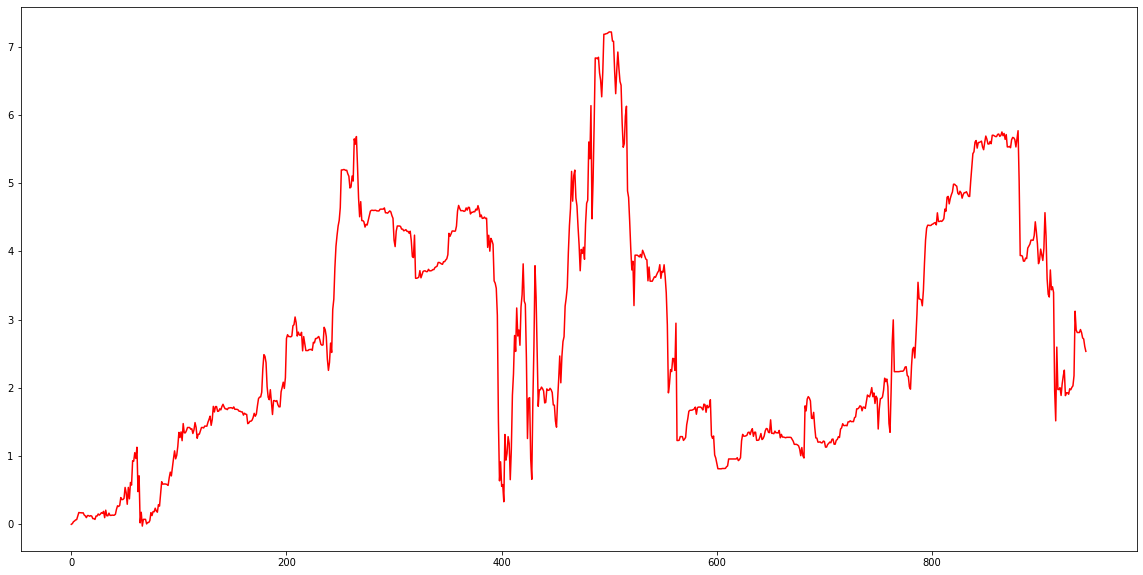

0.34951781669492166
0.34951781669492166
0.34951781669492166
0.34951781669492166
0.34951781669492166
iter 95. reward: 12.029440
day 1510: buy 46 units at price 2702.500000, total balance 97297.500000
day 1511: buy 1 units at price 59.000000, total balance 97238.500000
day 1512: buy 1 units at price 59.610000, total balance 97178.890000
day 1514: buy 31 units at price 1866.200000, total balance 95312.690000
day 1515: buy 27 units at price 1627.020000, total balance 93685.670000
day 1516: buy 20 units at price 1215.800000, total balance 92469.870000
day 1518, sell 126 units at price 7712.460000, total balance 100182.330000,
day 1519: buy 21 units at price 1275.960000, total balance 98906.370000
day 1521: buy 12 units at price 728.880000, total balance 98177.490000
day 1523: buy 26 units at price 1544.400000, total balance 96633.090000
day 1524: buy 31 units at price 1826.830000, total balance 94806.260000
day 1525, sell 90 units at price 5337.000000, total balance 100143.260000,
day 1526:

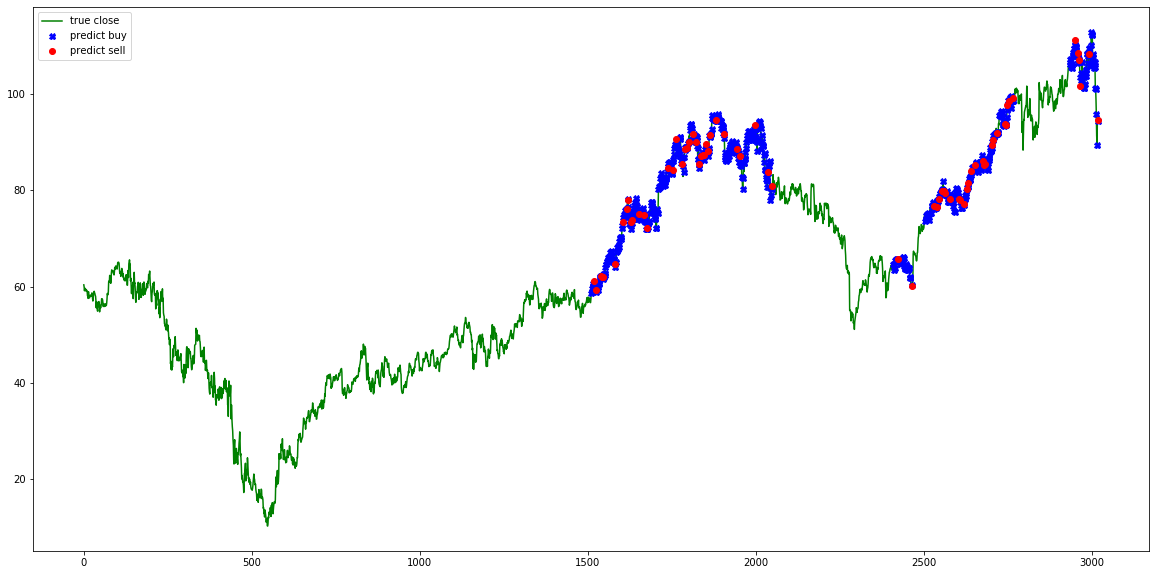

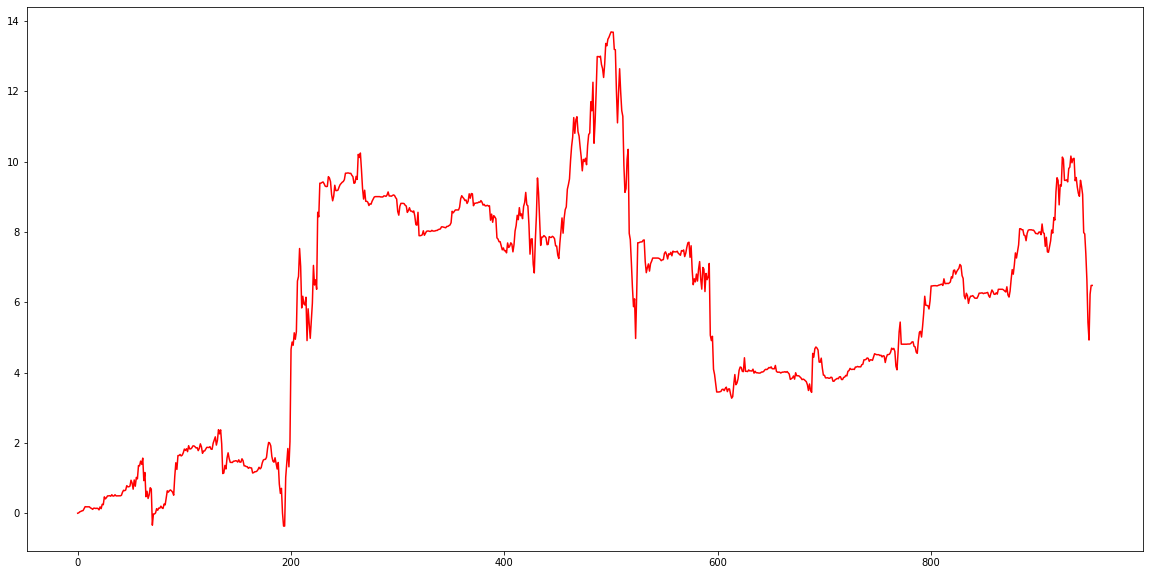

0.34951781669492166
0.34951781669492166
0.34951781669492166
0.34951781669492166
0.34951781669492166
iter 100. reward: 28.632400
day 1510: buy 52 units at price 3055.000000, total balance 96945.000000
day 1511: buy 1 units at price 59.000000, total balance 96886.000000
day 1512: buy 1 units at price 59.610000, total balance 96826.390000
day 1514: buy 31 units at price 1866.200000, total balance 94960.190000
day 1515: buy 28 units at price 1687.280000, total balance 93272.910000
day 1516: buy 28 units at price 1702.120000, total balance 91570.790000
day 1518, sell 141 units at price 8630.610000, total balance 100201.400000,
day 1519: buy 26 units at price 1579.760000, total balance 98621.640000
day 1521: buy 15 units at price 911.100000, total balance 97710.540000
day 1523: buy 22 units at price 1306.800000, total balance 96403.740000
day 1524: buy 36 units at price 2121.480000, total balance 94282.260000
day 1525, sell 99 units at price 5870.700000, total balance 100152.960000,
day 1526

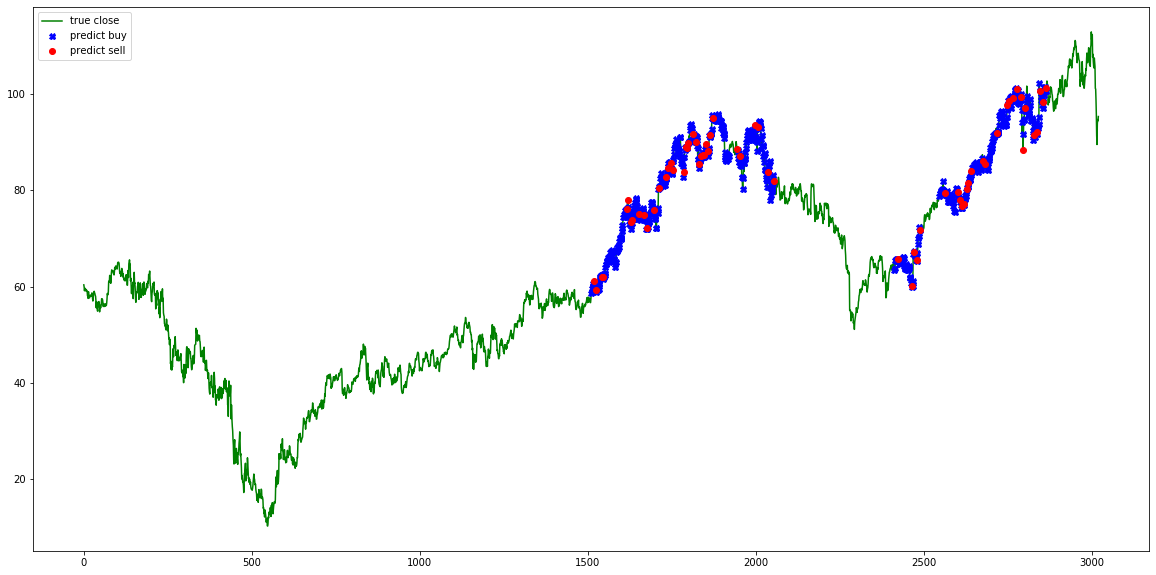

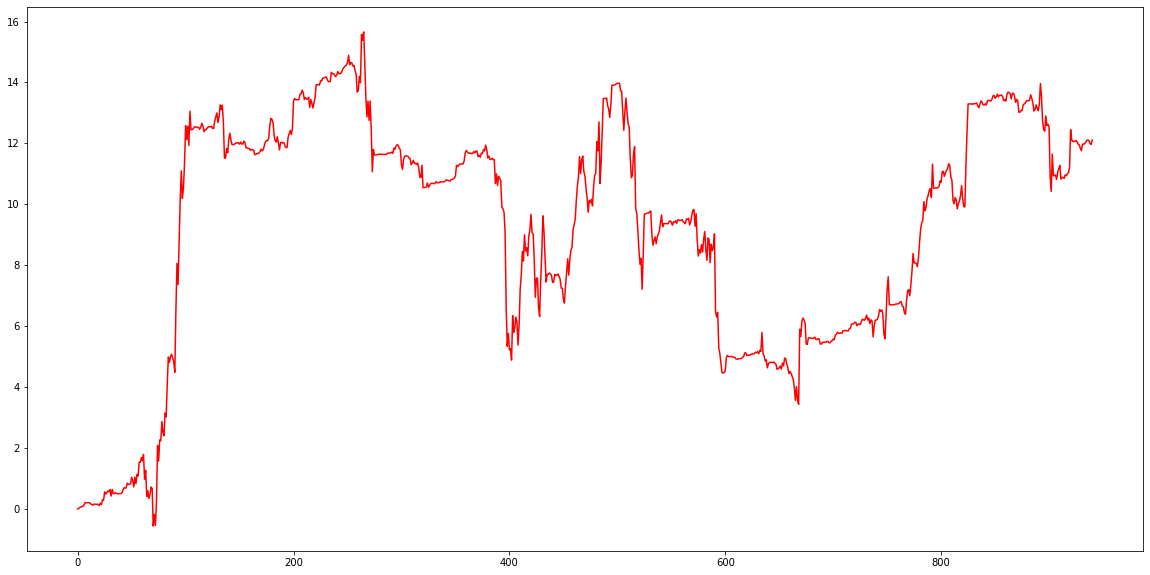

0.34951781669492166
0.34951781669492166
0.33204192586017556
0.33204192586017556
0.31543982956716676
iter 105. reward: 72.207767
day 1510: buy 65 units at price 3818.750000, total balance 96181.250000
day 1511: buy 1 units at price 59.000000, total balance 96122.250000
day 1512: buy 4 units at price 238.440000, total balance 95883.810000
day 1514: buy 42 units at price 2528.400000, total balance 93355.410000
day 1515: buy 34 units at price 2048.840000, total balance 91306.570000
day 1516: buy 37 units at price 2249.230000, total balance 89057.340000
day 1518: buy 28 units at price 1713.880000, total balance 87343.460000
day 1519: buy 38 units at price 2308.880000, total balance 85034.580000
day 1521: buy 20 units at price 1214.800000, total balance 83819.780000
day 1523: buy 28 units at price 1663.200000, total balance 82156.580000
day 1524: buy 44 units at price 2592.920000, total balance 79563.660000
day 1525, sell 341 units at price 20221.300000, total balance 99784.960000,
day 1526:

0.31543982956716676
0.2996678380888084
0.284684446184368
0.2704502238751496
0.25692771268139214
iter 110. reward: 136.318163
day 1510: buy 65 units at price 3818.750000, total balance 96181.250000
day 1511: buy 1 units at price 59.000000, total balance 96122.250000
day 1512: buy 4 units at price 238.440000, total balance 95883.810000
day 1514: buy 49 units at price 2949.800000, total balance 92934.010000
day 1515: buy 32 units at price 1928.320000, total balance 91005.690000
day 1516: buy 46 units at price 2796.340000, total balance 88209.350000
day 1517: buy 57 units at price 3490.680000, total balance 84718.670000
day 1518: buy 27 units at price 1652.670000, total balance 83066.000000
day 1519: buy 44 units at price 2673.440000, total balance 80392.560000
day 1521: buy 19 units at price 1154.060000, total balance 79238.500000
day 1522: buy 28 units at price 1673.840000, total balance 77564.660000
day 1523: buy 33 units at price 1960.200000, total balance 75604.460000
day 1524: buy 52

0.24408132704732252
0.24408132704732252
0.21967319434259028
0.21967319434259028
0.21967319434259028
iter 115. reward: 132.477892
day 1510: buy 69 units at price 4053.750000, total balance 95946.250000
day 1511: buy 1 units at price 59.000000, total balance 95887.250000
day 1512: buy 1 units at price 59.610000, total balance 95827.640000
day 1514: buy 42 units at price 2528.400000, total balance 93299.240000
day 1515: buy 36 units at price 2169.360000, total balance 91129.880000
day 1516: buy 55 units at price 3343.450000, total balance 87786.430000
day 1517: buy 53 units at price 3245.720000, total balance 84540.710000
day 1518: buy 34 units at price 2081.140000, total balance 82459.570000
day 1519: buy 48 units at price 2916.480000, total balance 79543.090000
day 1521: buy 27 units at price 1639.980000, total balance 77903.110000
day 1522: buy 24 units at price 1434.720000, total balance 76468.390000
day 1523: buy 34 units at price 2019.600000, total balance 74448.790000
day 1524: buy

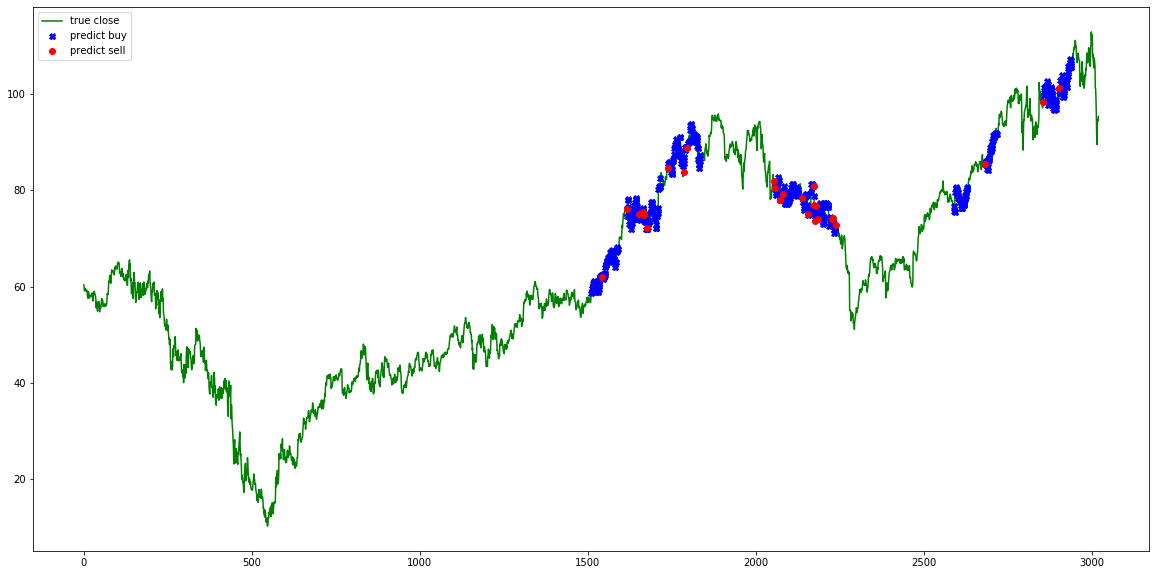

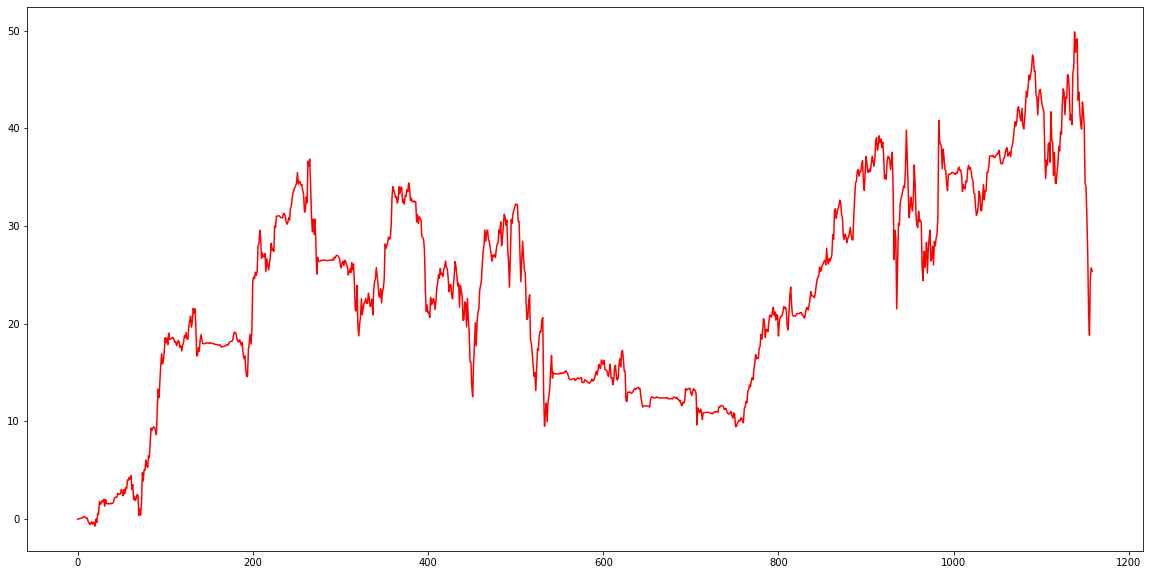

0.21967319434259028
0.19770587490833125
0.19770587490833125
0.19770587490833125
0.17793528741749812
iter 120. reward: 154.267418
day 1510: buy 71 units at price 4171.250000, total balance 95828.750000
day 1511: buy 1 units at price 59.000000, total balance 95769.750000
day 1512: buy 4 units at price 238.440000, total balance 95531.310000
day 1514: buy 46 units at price 2769.200000, total balance 92762.110000
day 1515: buy 46 units at price 2771.960000, total balance 89990.150000
day 1516: buy 53 units at price 3221.870000, total balance 86768.280000
day 1517: buy 52 units at price 3184.480000, total balance 83583.800000
day 1518: buy 38 units at price 2325.980000, total balance 81257.820000
day 1519: buy 50 units at price 3038.000000, total balance 78219.820000
day 1521: buy 27 units at price 1639.980000, total balance 76579.840000
day 1522: buy 25 units at price 1494.500000, total balance 75085.340000
day 1523: buy 34 units at price 2019.600000, total balance 73065.740000
day 1524: bu

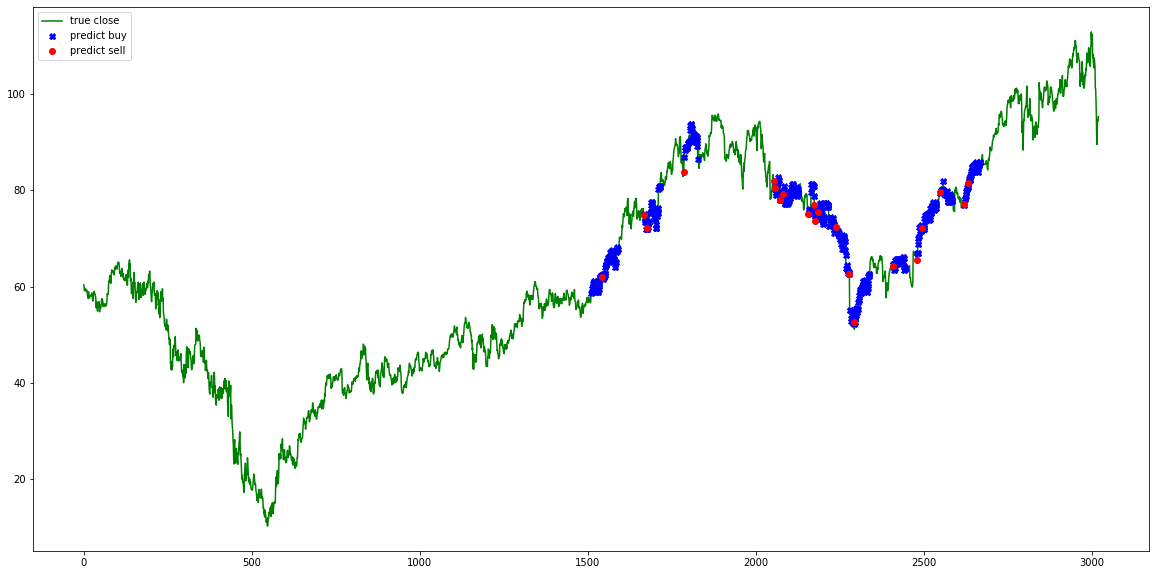

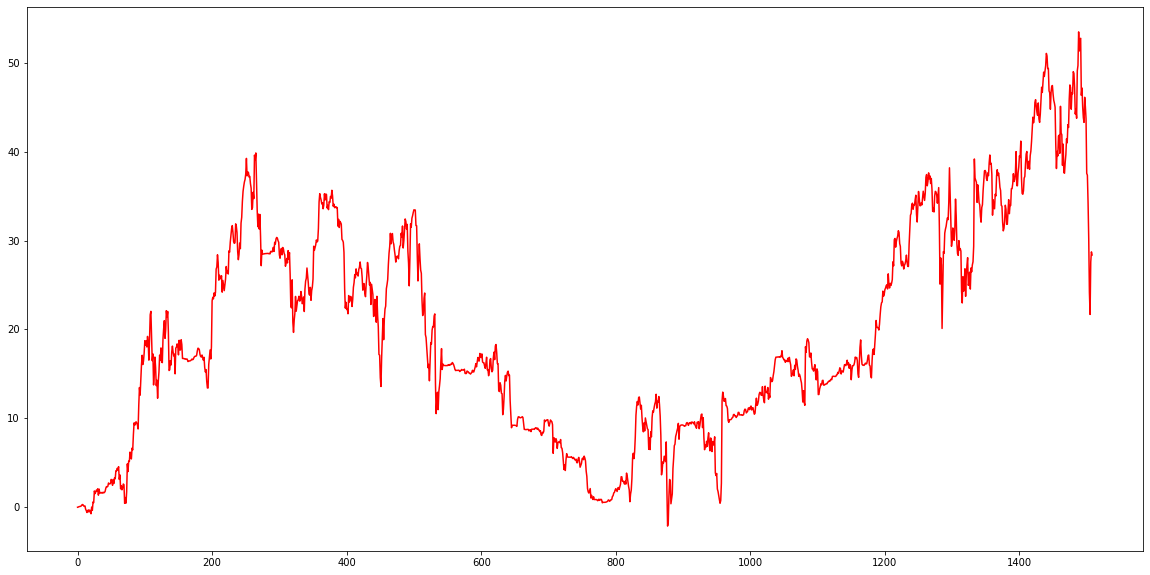

0.17793528741749812
0.17793528741749812
0.17793528741749812
0.1601417586757483
0.1601417586757483
iter 125. reward: 161.478653
day 1510: buy 70 units at price 4112.500000, total balance 95887.500000
day 1511: buy 1 units at price 59.000000, total balance 95828.500000
day 1512: buy 12 units at price 715.320000, total balance 95113.180000
day 1514: buy 45 units at price 2709.000000, total balance 92404.180000
day 1515: buy 48 units at price 2892.480000, total balance 89511.700000
day 1516: buy 43 units at price 2613.970000, total balance 86897.730000
day 1517: buy 48 units at price 2939.520000, total balance 83958.210000
day 1518: buy 38 units at price 2325.980000, total balance 81632.230000
day 1519: buy 46 units at price 2794.960000, total balance 78837.270000
day 1521: buy 28 units at price 1700.720000, total balance 77136.550000
day 1522: buy 20 units at price 1195.600000, total balance 75940.950000
day 1523: buy 34 units at price 2019.600000, total balance 73921.350000
day 1524: buy

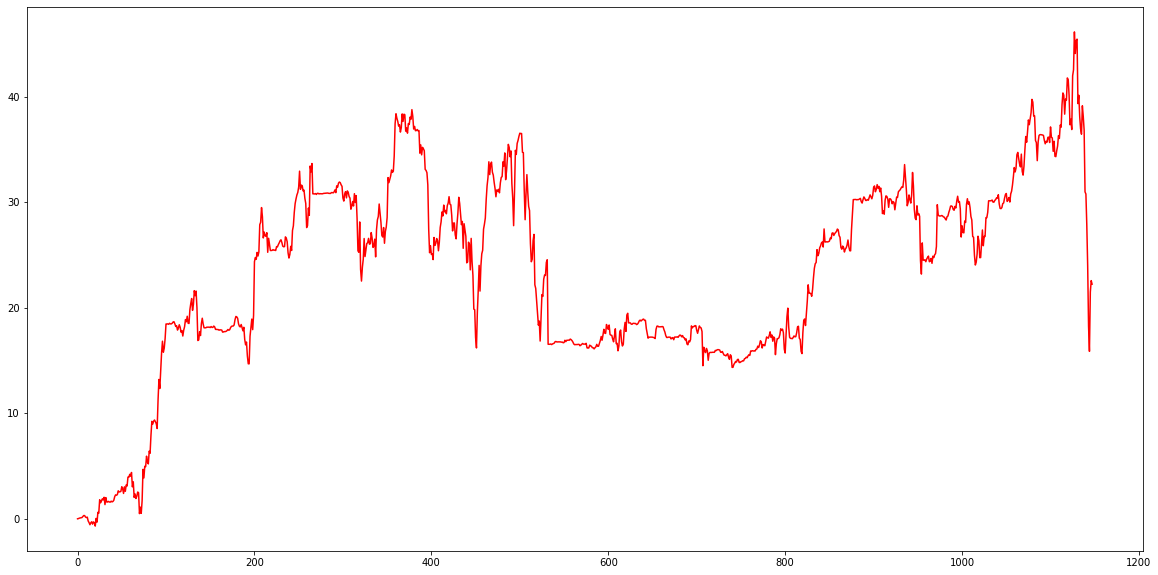

0.14412758280817348
0.12971482452735614
0.11674334207462053
0.08973974243759585
0.08973974243759585
iter 130. reward: 173.759398
day 1510: buy 63 units at price 3701.250000, total balance 96298.750000
day 1511: buy 1 units at price 59.000000, total balance 96239.750000
day 1512: buy 21 units at price 1251.810000, total balance 94987.940000
day 1514: buy 36 units at price 2167.200000, total balance 92820.740000
day 1515: buy 39 units at price 2350.140000, total balance 90470.600000
day 1516: buy 47 units at price 2857.130000, total balance 87613.470000
day 1517: buy 48 units at price 2939.520000, total balance 84673.950000
day 1518: buy 32 units at price 1958.720000, total balance 82715.230000
day 1519: buy 43 units at price 2612.680000, total balance 80102.550000
day 1521: buy 22 units at price 1336.280000, total balance 78766.270000
day 1522: buy 15 units at price 896.700000, total balance 77869.570000
day 1523: buy 42 units at price 2494.800000, total balance 75374.770000
day 1524: b

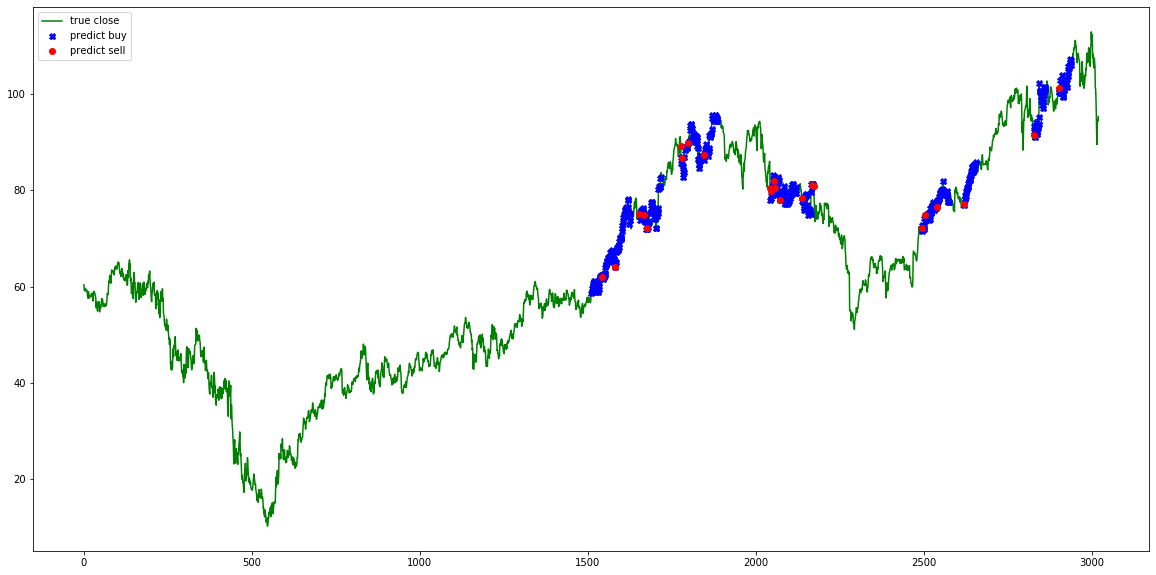

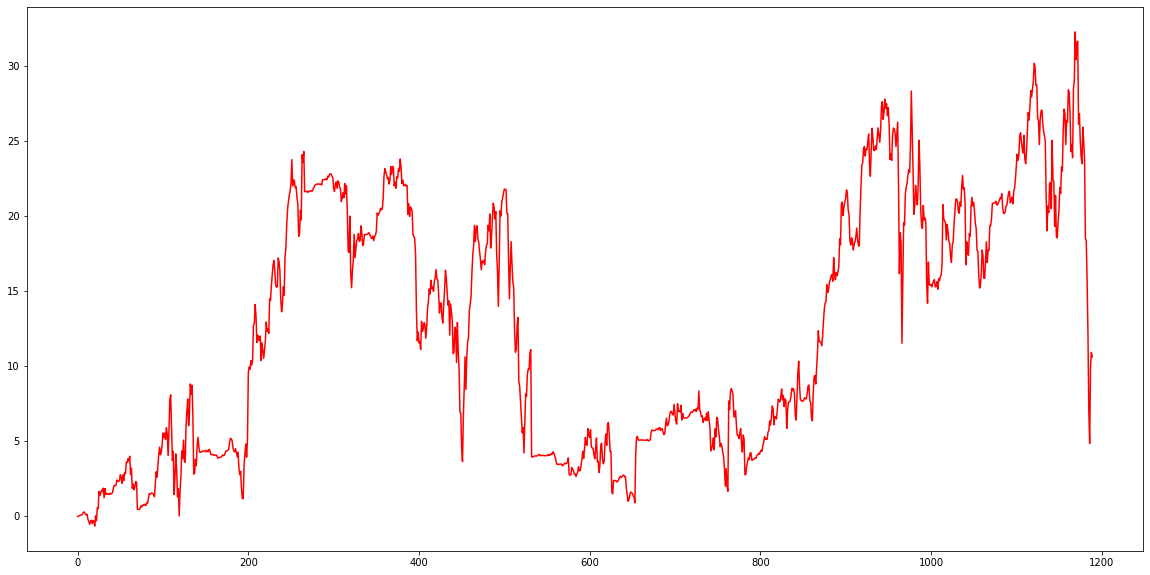

0.074285487292738
0.074285487292738
0.074285487292738
0.074285487292738
0.074285487292738
iter 135. reward: 200.500330
day 1510: buy 59 units at price 3466.250000, total balance 96533.750000
day 1511: buy 1 units at price 59.000000, total balance 96474.750000
day 1512: buy 18 units at price 1072.980000, total balance 95401.770000
day 1514: buy 46 units at price 2769.200000, total balance 92632.570000
day 1515: buy 34 units at price 2048.840000, total balance 90583.730000
day 1516: buy 49 units at price 2978.710000, total balance 87605.020000
day 1517: buy 42 units at price 2572.080000, total balance 85032.940000
day 1518: buy 29 units at price 1775.090000, total balance 83257.850000
day 1519: buy 40 units at price 2430.400000, total balance 80827.450000
day 1521: buy 22 units at price 1336.280000, total balance 79491.170000
day 1522: buy 17 units at price 1016.260000, total balance 78474.910000
day 1523: buy 33 units at price 1960.200000, total balance 76514.710000
day 1524: buy 60 uni

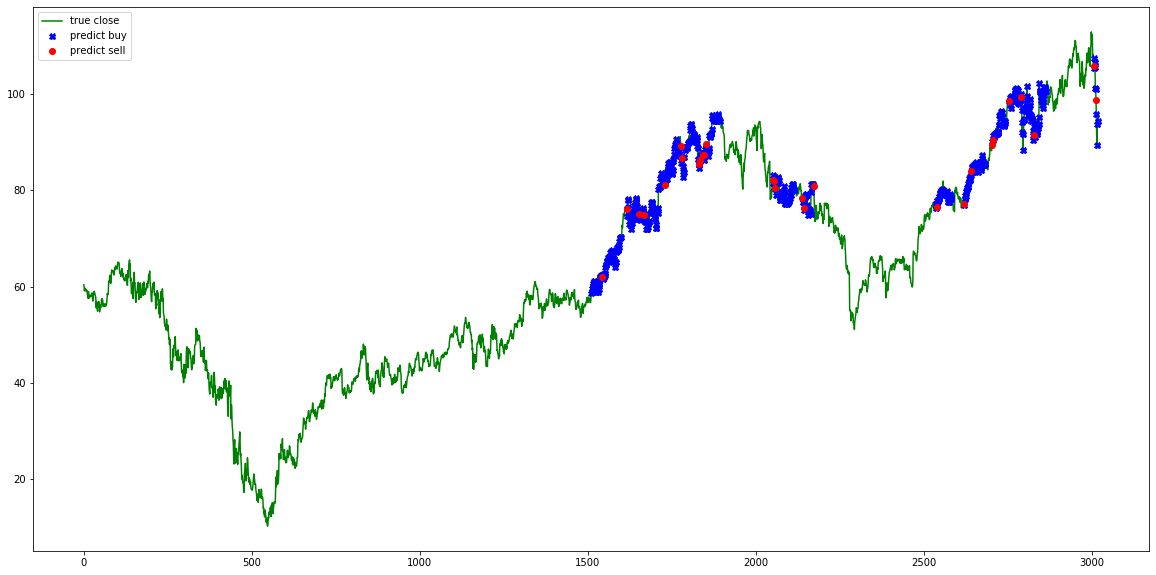

0.060631601539340295
0.060631601539340295
0.060631601539340295
0.060631601539340295
0.060631601539340295
iter 140. reward: 211.188470
day 1510: buy 62 units at price 3642.500000, total balance 96357.500000
day 1511: buy 1 units at price 59.000000, total balance 96298.500000
day 1512: buy 15 units at price 894.150000, total balance 95404.350000
day 1514: buy 56 units at price 3371.200000, total balance 92033.150000
day 1515: buy 42 units at price 2530.920000, total balance 89502.230000
day 1516: buy 52 units at price 3161.080000, total balance 86341.150000
day 1517: buy 44 units at price 2694.560000, total balance 83646.590000
day 1518: buy 33 units at price 2019.930000, total balance 81626.660000
day 1519: buy 49 units at price 2977.240000, total balance 78649.420000
day 1521: buy 26 units at price 1579.240000, total balance 77070.180000
day 1522: buy 27 units at price 1614.060000, total balance 75456.120000
day 1523: buy 41 units at price 2435.400000, total balance 73020.720000
day 15

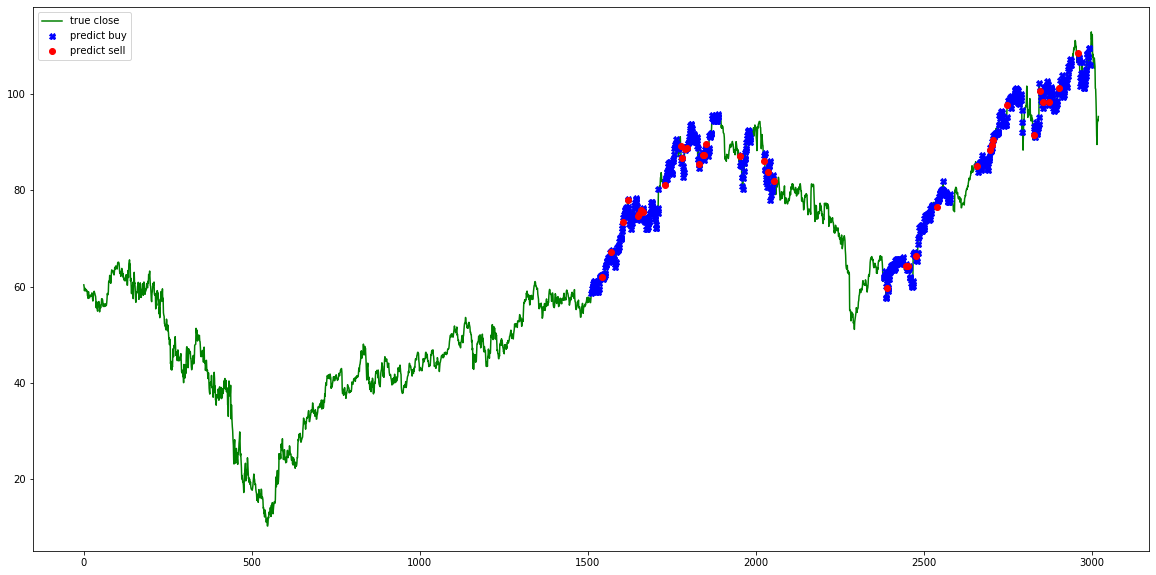

0.060631601539340295
0.060631601539340295
0.060631601539340295
0.060631601539340295
0.060631601539340295
iter 145. reward: 194.478205
day 1510: buy 65 units at price 3818.750000, total balance 96181.250000
day 1511: buy 1 units at price 59.000000, total balance 96122.250000
day 1512: buy 8 units at price 476.880000, total balance 95645.370000
day 1514: buy 63 units at price 3792.600000, total balance 91852.770000
day 1515: buy 46 units at price 2771.960000, total balance 89080.810000
day 1516: buy 50 units at price 3039.500000, total balance 86041.310000
day 1517: buy 45 units at price 2755.800000, total balance 83285.510000
day 1518: buy 34 units at price 2081.140000, total balance 81204.370000
day 1519: buy 51 units at price 3098.760000, total balance 78105.610000
day 1521: buy 29 units at price 1761.460000, total balance 76344.150000
day 1522: buy 27 units at price 1614.060000, total balance 74730.090000
day 1523: buy 39 units at price 2316.600000, total balance 72413.490000
day 152

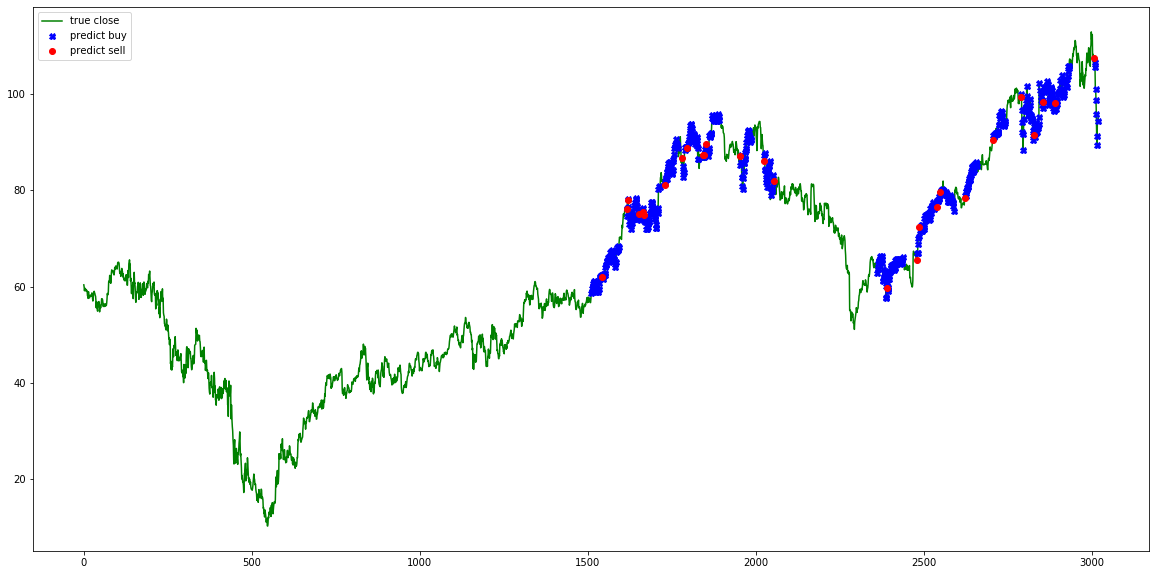

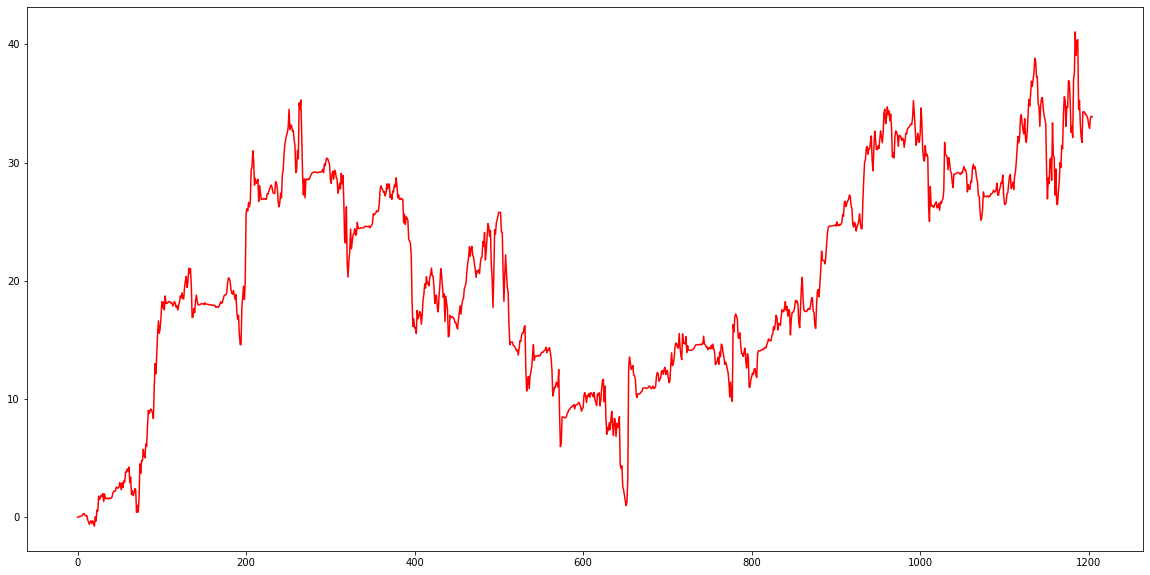

0.060631601539340295
0.060631601539340295
0.031356118024674744
0.031356118024674744
0.031356118024674744
iter 150. reward: 202.802385
day 1510: buy 64 units at price 3760.000000, total balance 96240.000000
day 1511: buy 1 units at price 59.000000, total balance 96181.000000
day 1512: buy 5 units at price 298.050000, total balance 95882.950000
day 1514: buy 60 units at price 3612.000000, total balance 92270.950000
day 1515: buy 36 units at price 2169.360000, total balance 90101.590000
day 1516: buy 47 units at price 2857.130000, total balance 87244.460000
day 1517: buy 40 units at price 2449.600000, total balance 84794.860000
day 1518: buy 28 units at price 1713.880000, total balance 83080.980000
day 1519: buy 56 units at price 3402.560000, total balance 79678.420000
day 1520: buy 15 units at price 909.300000, total balance 78769.120000
day 1521: buy 33 units at price 2004.420000, total balance 76764.700000
day 1522: buy 30 units at price 1793.400000, total balance 74971.300000
day 1523

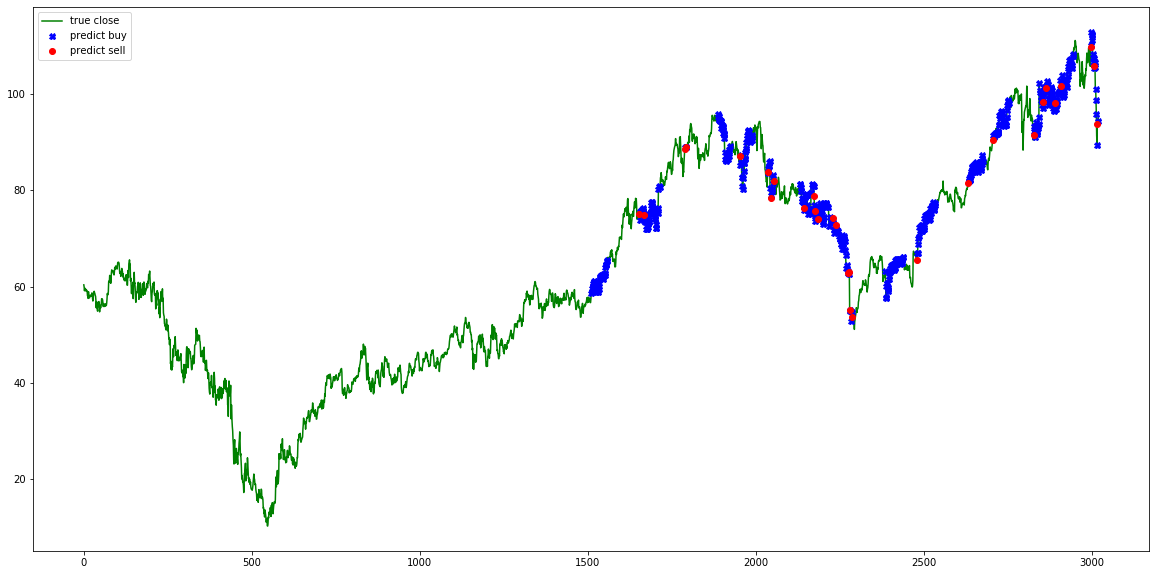

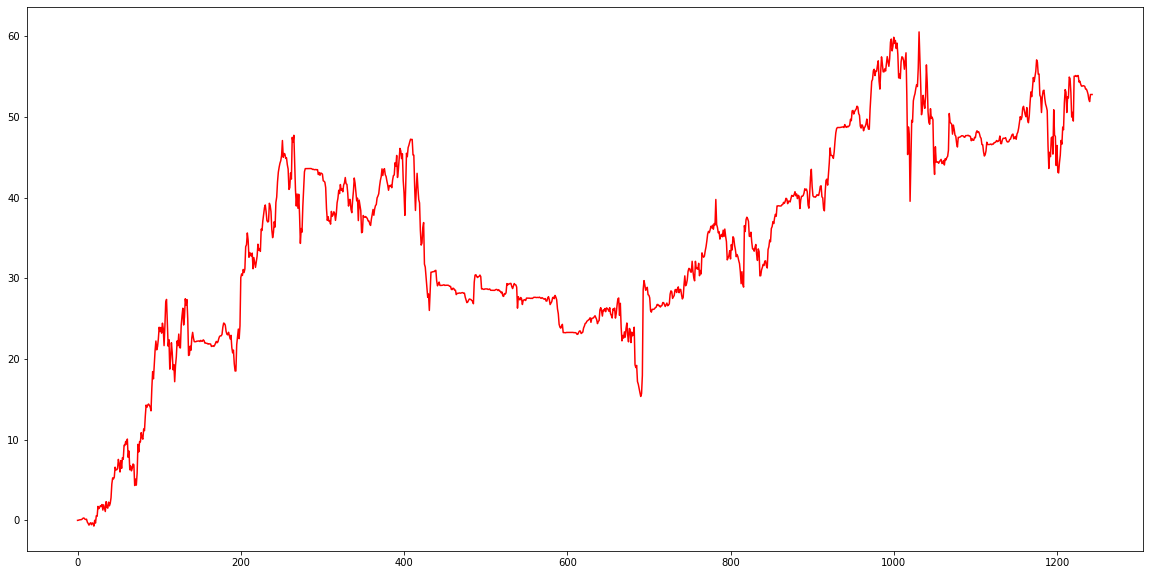

0.031356118024674744
0.031356118024674744
0.031356118024674744
0.031356118024674744
0.031356118024674744
iter 155. reward: 193.745145
day 1510: buy 62 units at price 3642.500000, total balance 96357.500000
day 1511: buy 1 units at price 59.000000, total balance 96298.500000
day 1512: buy 17 units at price 1013.370000, total balance 95285.130000
day 1514: buy 67 units at price 4033.400000, total balance 91251.730000
day 1515: buy 34 units at price 2048.840000, total balance 89202.890000
day 1516: buy 46 units at price 2796.340000, total balance 86406.550000
day 1518: buy 28 units at price 1713.880000, total balance 84692.670000
day 1519: buy 54 units at price 3281.040000, total balance 81411.630000
day 1521: buy 30 units at price 1822.200000, total balance 79589.430000
day 1522: buy 34 units at price 2032.520000, total balance 77556.910000
day 1523: buy 25 units at price 1485.000000, total balance 76071.910000
day 1524: buy 71 units at price 4184.030000, total balance 71887.880000
day 1

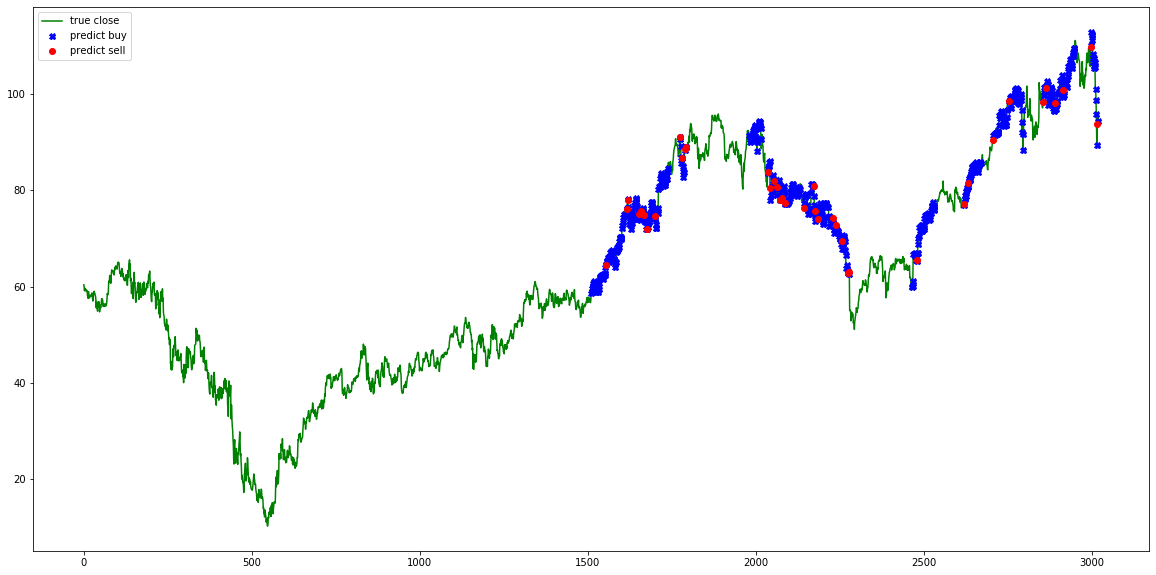

0.031356118024674744
0.031356118024674744
0.031356118024674744
0.031356118024674744
0.031356118024674744
iter 160. reward: 178.740162
day 1510: buy 63 units at price 3701.250000, total balance 96298.750000
day 1511: buy 2 units at price 118.000000, total balance 96180.750000
day 1512: buy 14 units at price 834.540000, total balance 95346.210000
day 1514: buy 64 units at price 3852.800000, total balance 91493.410000
day 1515: buy 38 units at price 2289.880000, total balance 89203.530000
day 1516: buy 48 units at price 2917.920000, total balance 86285.610000
day 1517: buy 47 units at price 2878.280000, total balance 83407.330000
day 1518: buy 25 units at price 1530.250000, total balance 81877.080000
day 1519: buy 51 units at price 3098.760000, total balance 78778.320000
day 1521: buy 26 units at price 1579.240000, total balance 77199.080000
day 1522: buy 35 units at price 2092.300000, total balance 75106.780000
day 1523: buy 24 units at price 1425.600000, total balance 73681.180000
day 1

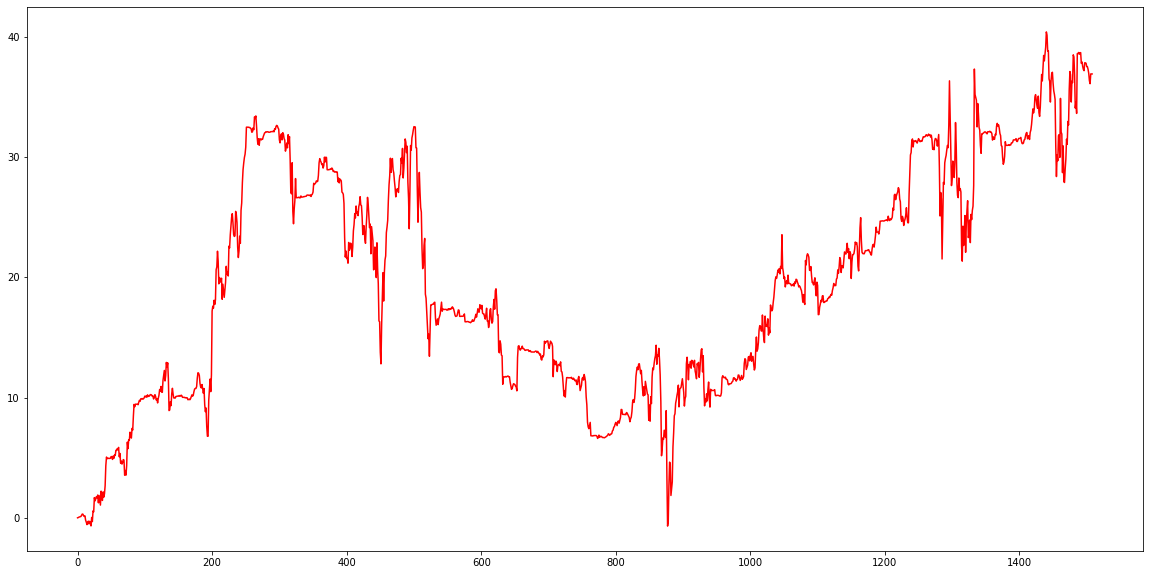

0.031356118024674744
0.031356118024674744
0.031356118024674744
0.031356118024674744
0.031356118024674744
iter 165. reward: 202.473343
day 1510: buy 67 units at price 3936.250000, total balance 96063.750000
day 1511: buy 2 units at price 118.000000, total balance 95945.750000
day 1512: buy 12 units at price 715.320000, total balance 95230.430000
day 1514: buy 62 units at price 3732.400000, total balance 91498.030000
day 1515: buy 31 units at price 1868.060000, total balance 89629.970000
day 1516: buy 55 units at price 3343.450000, total balance 86286.520000
day 1517, sell 229 units at price 14023.960000, total balance 100310.480000,
day 1518: buy 19 units at price 1162.990000, total balance 99147.490000
day 1519: buy 55 units at price 3341.800000, total balance 95805.690000
day 1521: buy 38 units at price 2308.120000, total balance 93497.570000
day 1522: buy 37 units at price 2211.860000, total balance 91285.710000
day 1523: buy 24 units at price 1425.600000, total balance 89860.110000


0.031356118024674744
0.031356118024674744
0.031356118024674744
0.031356118024674744
0.031356118024674744
iter 170. reward: 193.320220
day 1510: buy 65 units at price 3818.750000, total balance 96181.250000
day 1511: buy 1 units at price 59.000000, total balance 96122.250000
day 1512: buy 21 units at price 1251.810000, total balance 94870.440000
day 1514: buy 62 units at price 3732.400000, total balance 91138.040000
day 1515: buy 35 units at price 2109.100000, total balance 89028.940000
day 1516: buy 57 units at price 3465.030000, total balance 85563.910000
day 1518: buy 16 units at price 979.360000, total balance 84584.550000
day 1519: buy 54 units at price 3281.040000, total balance 81303.510000
day 1521: buy 26 units at price 1579.240000, total balance 79724.270000
day 1522: buy 35 units at price 2092.300000, total balance 77631.970000
day 1523: buy 26 units at price 1544.400000, total balance 76087.570000
day 1526: buy 41 units at price 2439.500000, total balance 73648.070000
day 15

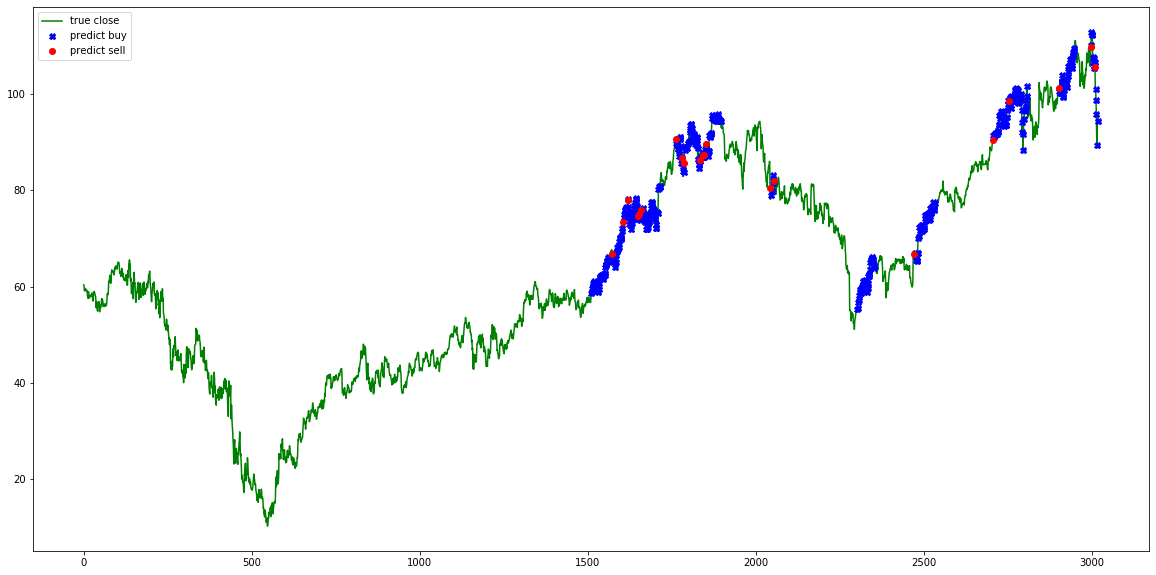

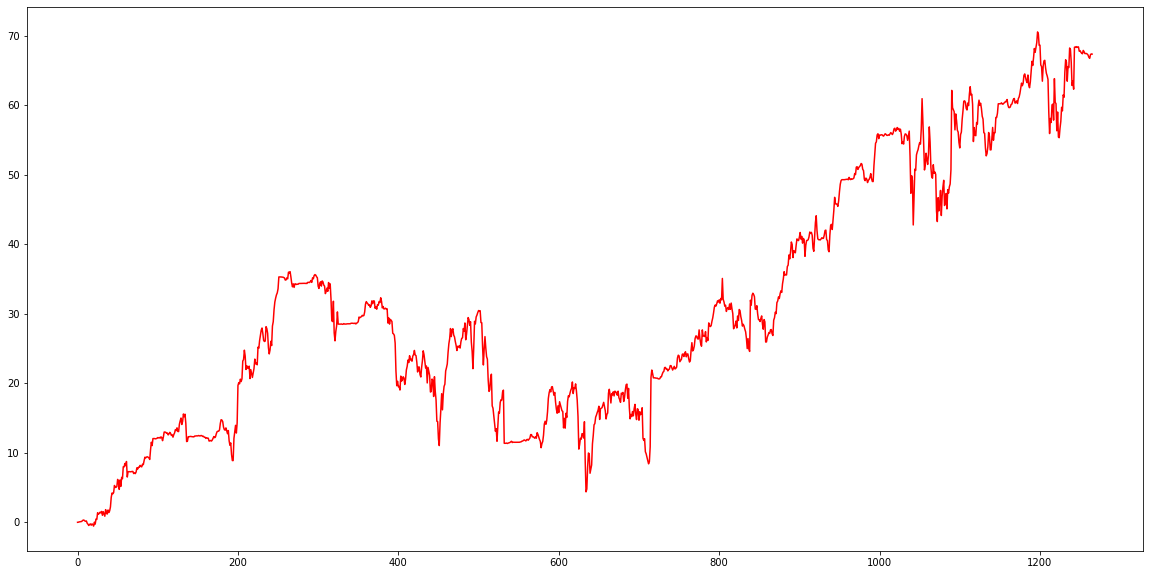

0.031356118024674744
0.031356118024674744
0.031356118024674744
0.031356118024674744
0.031356118024674744
iter 175. reward: 130.992245
day 1510: buy 65 units at price 3818.750000, total balance 96181.250000
day 1511: buy 1 units at price 59.000000, total balance 96122.250000
day 1512: buy 32 units at price 1907.520000, total balance 94214.730000
day 1514: buy 66 units at price 3973.200000, total balance 90241.530000
day 1515: buy 32 units at price 1928.320000, total balance 88313.210000
day 1516: buy 57 units at price 3465.030000, total balance 84848.180000
day 1517, sell 253 units at price 15493.720000, total balance 100341.900000,
day 1518: buy 16 units at price 979.360000, total balance 99362.540000
day 1519: buy 52 units at price 3159.520000, total balance 96203.020000
day 1520: buy 16 units at price 969.920000, total balance 95233.100000
day 1521: buy 22 units at price 1336.280000, total balance 93896.820000
day 1522: buy 32 units at price 1912.960000, total balance 91983.860000
da

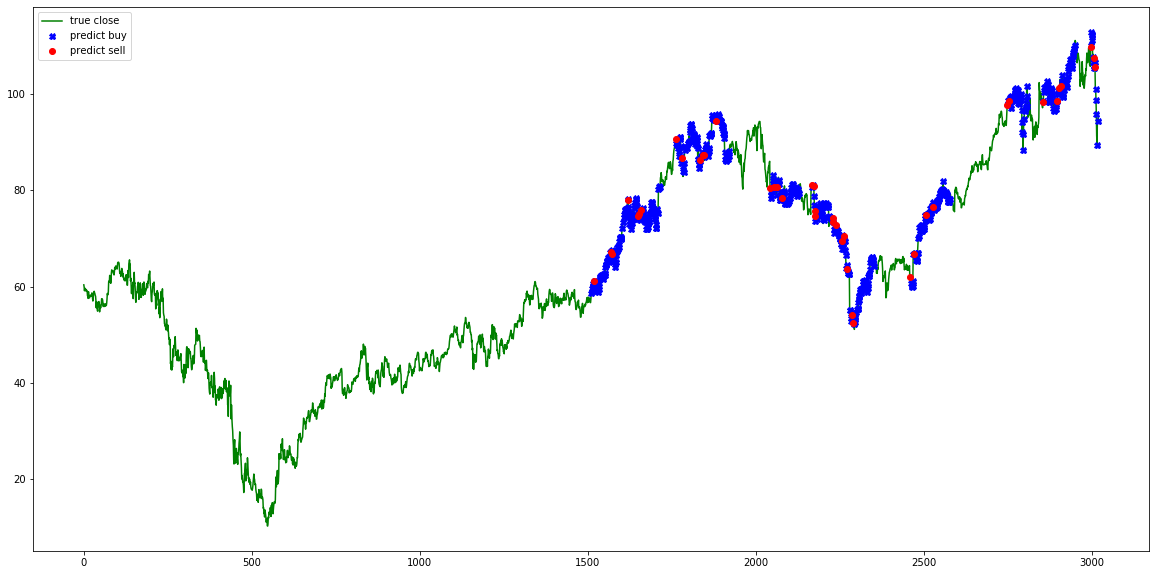

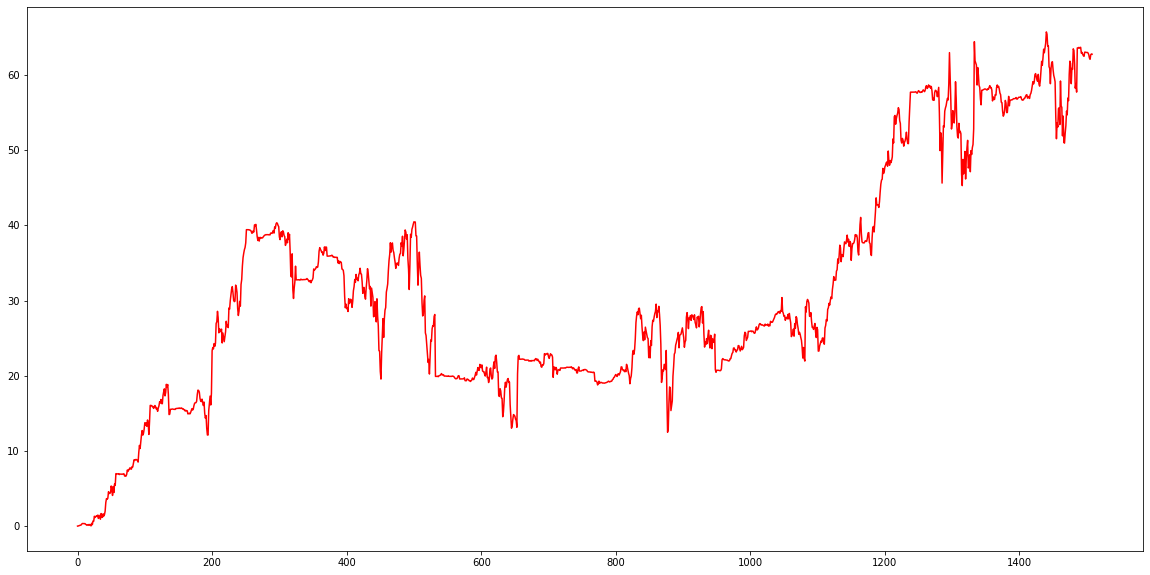

0.031356118024674744
0.031356118024674744
0.031356118024674744
0.031356118024674744
0.031356118024674744
iter 180. reward: 134.583345
day 1510: buy 73 units at price 4288.750000, total balance 95711.250000
day 1511: buy 1 units at price 59.000000, total balance 95652.250000
day 1512: buy 38 units at price 2265.180000, total balance 93387.070000
day 1514: buy 61 units at price 3672.200000, total balance 89714.870000
day 1515: buy 36 units at price 2169.360000, total balance 87545.510000
day 1516: buy 65 units at price 3951.350000, total balance 83594.160000
day 1517, sell 274 units at price 16779.760000, total balance 100373.920000,
day 1518: buy 20 units at price 1224.200000, total balance 99149.720000
day 1519: buy 61 units at price 3706.360000, total balance 95443.360000
day 1520: buy 15 units at price 909.300000, total balance 94534.060000
day 1521: buy 29 units at price 1761.460000, total balance 92772.600000
day 1522: buy 47 units at price 2809.660000, total balance 89962.940000
d

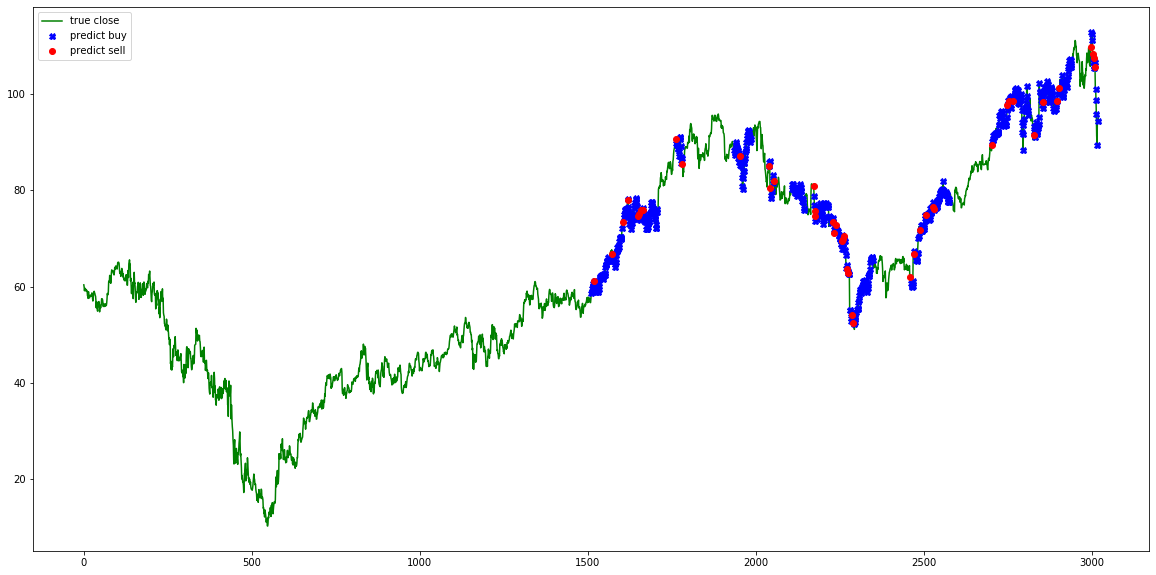

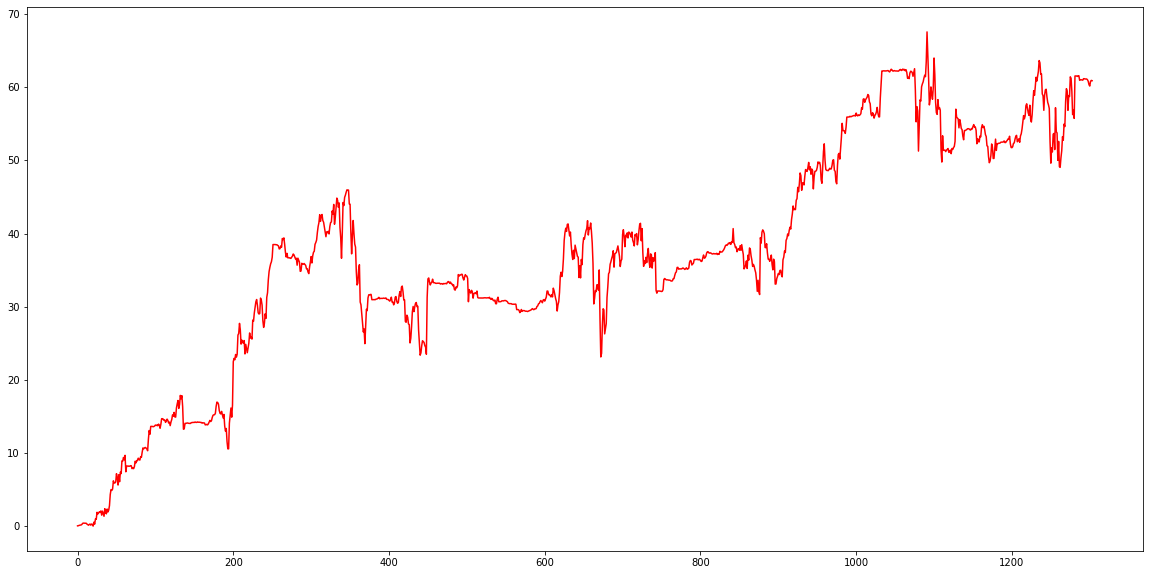

0.031356118024674744
0.031356118024674744
0.031356118024674744
0.031356118024674744
0.031356118024674744
iter 185. reward: 122.976395
day 1510: buy 69 units at price 4053.750000, total balance 95946.250000
day 1511: buy 3 units at price 177.000000, total balance 95769.250000
day 1512: buy 39 units at price 2324.790000, total balance 93444.460000
day 1514: buy 63 units at price 3792.600000, total balance 89651.860000
day 1515: buy 48 units at price 2892.480000, total balance 86759.380000
day 1516: buy 61 units at price 3708.190000, total balance 83051.190000
day 1517, sell 283 units at price 17330.920000, total balance 100382.110000,
day 1518: buy 21 units at price 1285.410000, total balance 99096.700000
day 1519: buy 63 units at price 3827.880000, total balance 95268.820000
day 1520: buy 11 units at price 666.820000, total balance 94602.000000
day 1521: buy 25 units at price 1518.500000, total balance 93083.500000
day 1522: buy 57 units at price 3407.460000, total balance 89676.040000


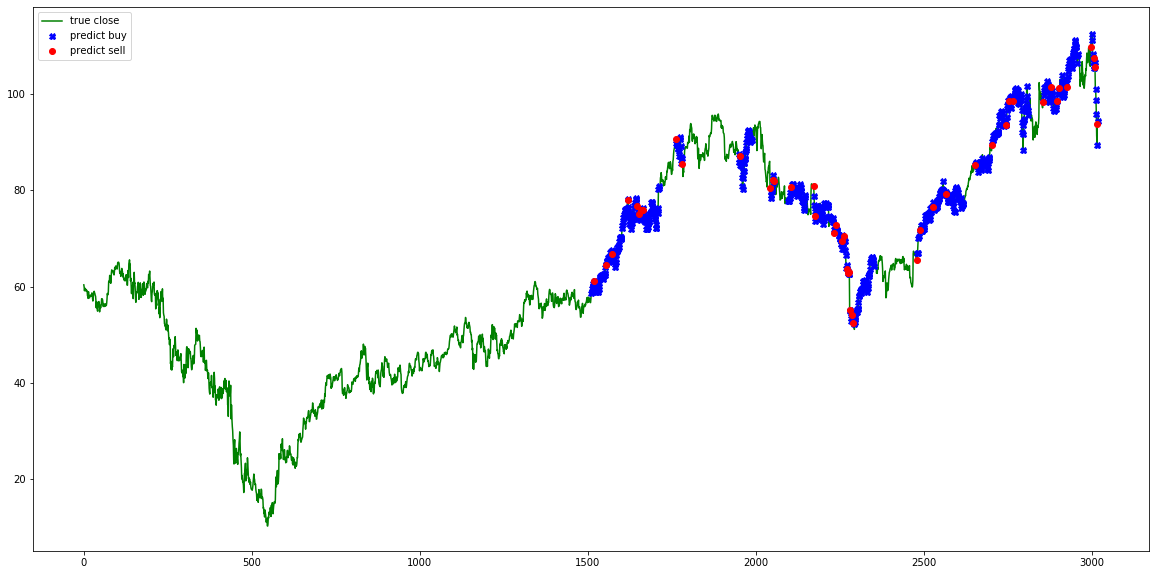

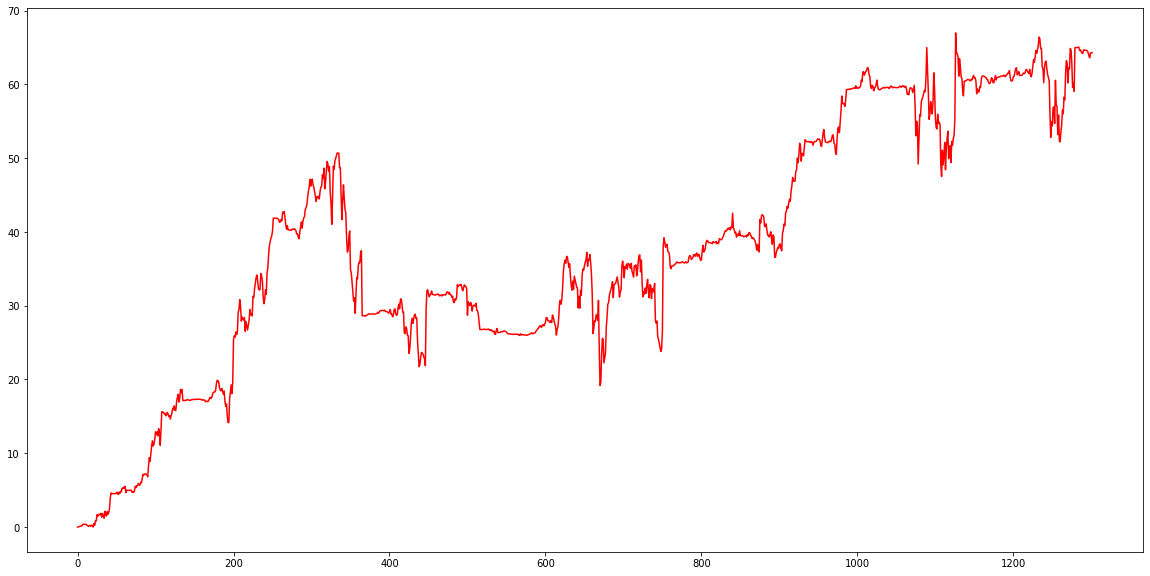

0.031356118024674744
0.031356118024674744
0.031356118024674744
0.031356118024674744
0.031356118024674744
iter 190. reward: 167.235335
day 1510: buy 64 units at price 3760.000000, total balance 96240.000000
day 1511: buy 2 units at price 118.000000, total balance 96122.000000
day 1512: buy 38 units at price 2265.180000, total balance 93856.820000
day 1514: buy 53 units at price 3190.600000, total balance 90666.220000
day 1515: buy 43 units at price 2591.180000, total balance 88075.040000
day 1516: buy 60 units at price 3647.400000, total balance 84427.640000
day 1517: buy 38 units at price 2327.120000, total balance 82100.520000
day 1518: buy 10 units at price 612.100000, total balance 81488.420000
day 1519: buy 67 units at price 4070.920000, total balance 77417.500000
day 1520: buy 5 units at price 303.100000, total balance 77114.400000
day 1521: buy 20 units at price 1214.800000, total balance 75899.600000
day 1522: buy 60 units at price 3586.800000, total balance 72312.800000
day 152

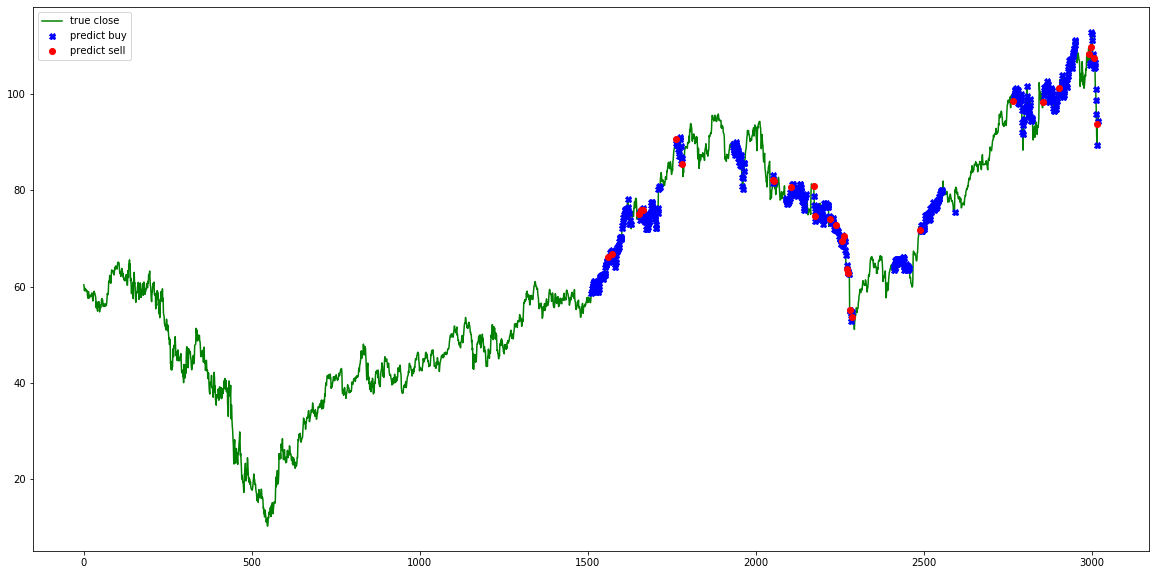

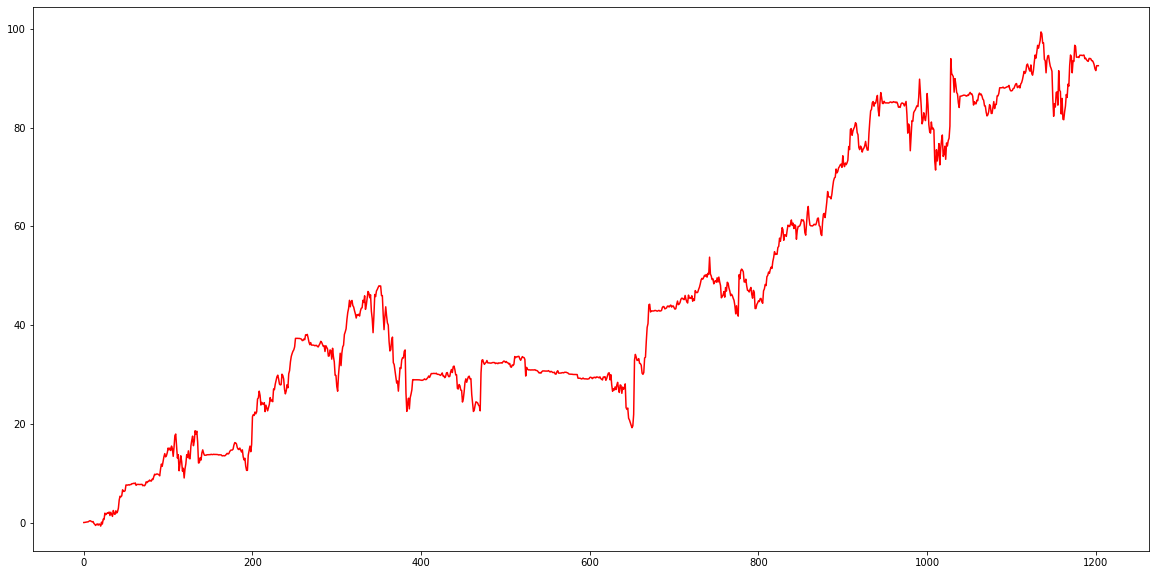

0.031356118024674744
0.031356118024674744
0.031356118024674744
0.031356118024674744
0.031356118024674744
iter 195. reward: 168.441710
day 1510: buy 68 units at price 3995.000000, total balance 96005.000000
day 1511: buy 1 units at price 59.000000, total balance 95946.000000
day 1512: buy 40 units at price 2384.400000, total balance 93561.600000
day 1514: buy 45 units at price 2709.000000, total balance 90852.600000
day 1515: buy 46 units at price 2771.960000, total balance 88080.640000
day 1516: buy 58 units at price 3525.820000, total balance 84554.820000
day 1517: buy 39 units at price 2388.360000, total balance 82166.460000
day 1518: buy 12 units at price 734.520000, total balance 81431.940000
day 1519: buy 66 units at price 4010.160000, total balance 77421.780000
day 1520: buy 16 units at price 969.920000, total balance 76451.860000
day 1521: buy 15 units at price 911.100000, total balance 75540.760000
day 1522: buy 69 units at price 4124.820000, total balance 71415.940000
day 1523

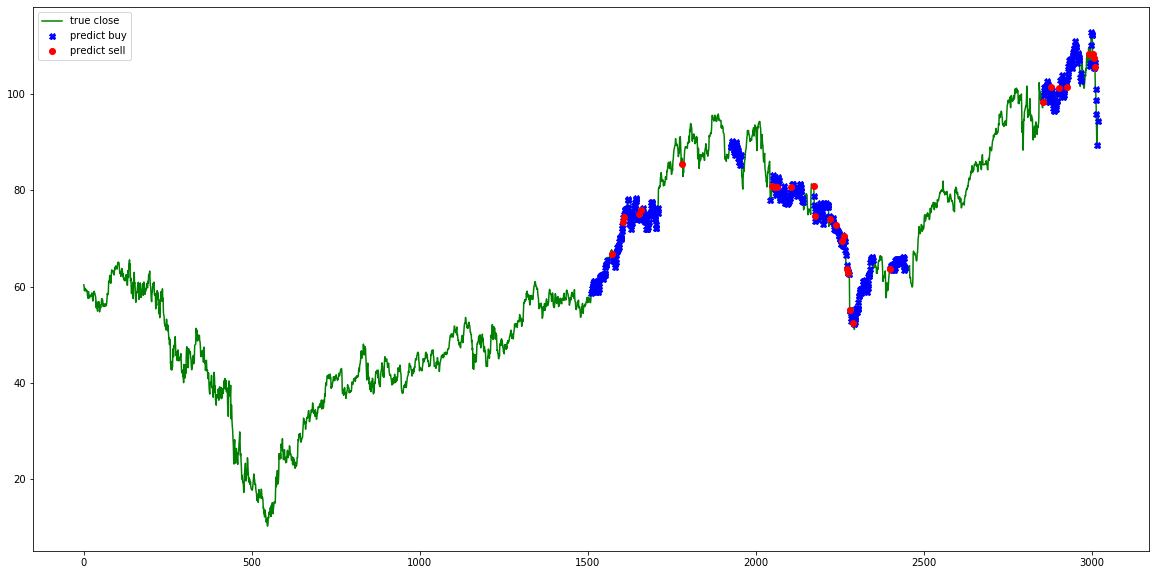

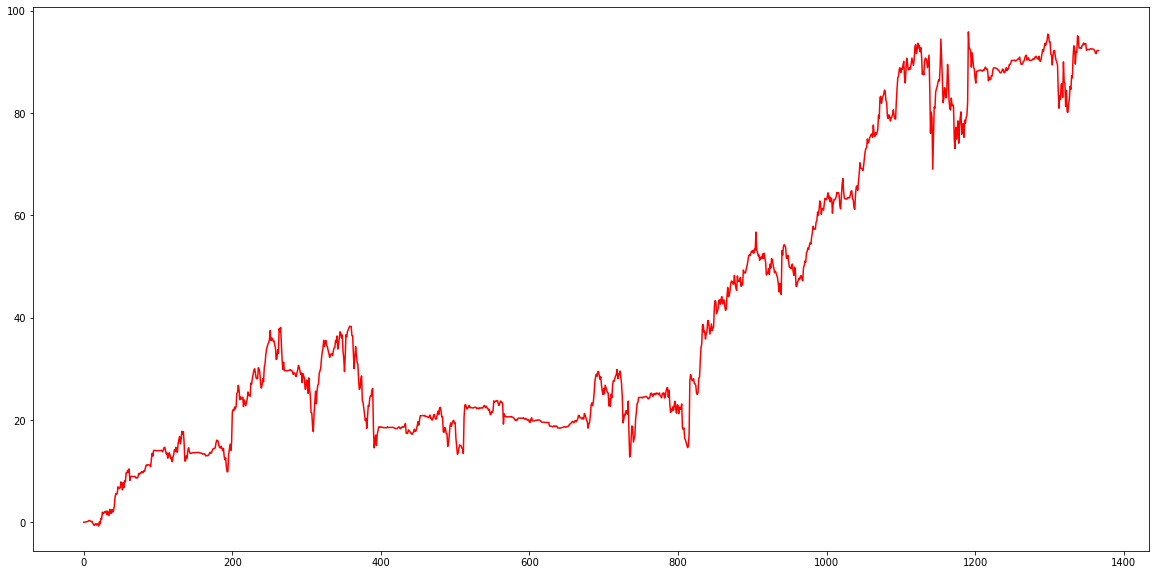

0.031356118024674744
0.031356118024674744
0.031356118024674744
0.031356118024674744
0.031356118024674744
iter 200. reward: 133.931747
day 1510: buy 66 units at price 3877.500000, total balance 96122.500000
day 1511: buy 1 units at price 59.000000, total balance 96063.500000
day 1512: buy 50 units at price 2980.500000, total balance 93083.000000
day 1514: buy 44 units at price 2648.800000, total balance 90434.200000
day 1515: buy 46 units at price 2771.960000, total balance 87662.240000
day 1516: buy 59 units at price 3586.610000, total balance 84075.630000
day 1517: buy 37 units at price 2265.880000, total balance 81809.750000
day 1518: buy 18 units at price 1101.780000, total balance 80707.970000
day 1519: buy 67 units at price 4070.920000, total balance 76637.050000
day 1521: buy 13 units at price 789.620000, total balance 75847.430000
day 1522: buy 66 units at price 3945.480000, total balance 71901.950000
day 1523: buy 34 units at price 2019.600000, total balance 69882.350000
day 15

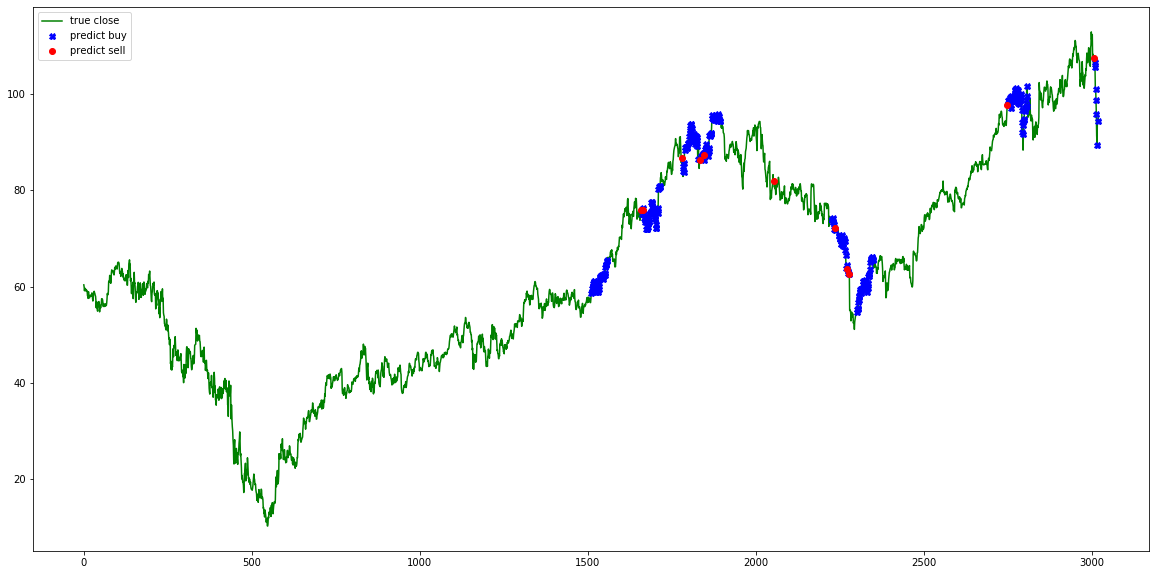

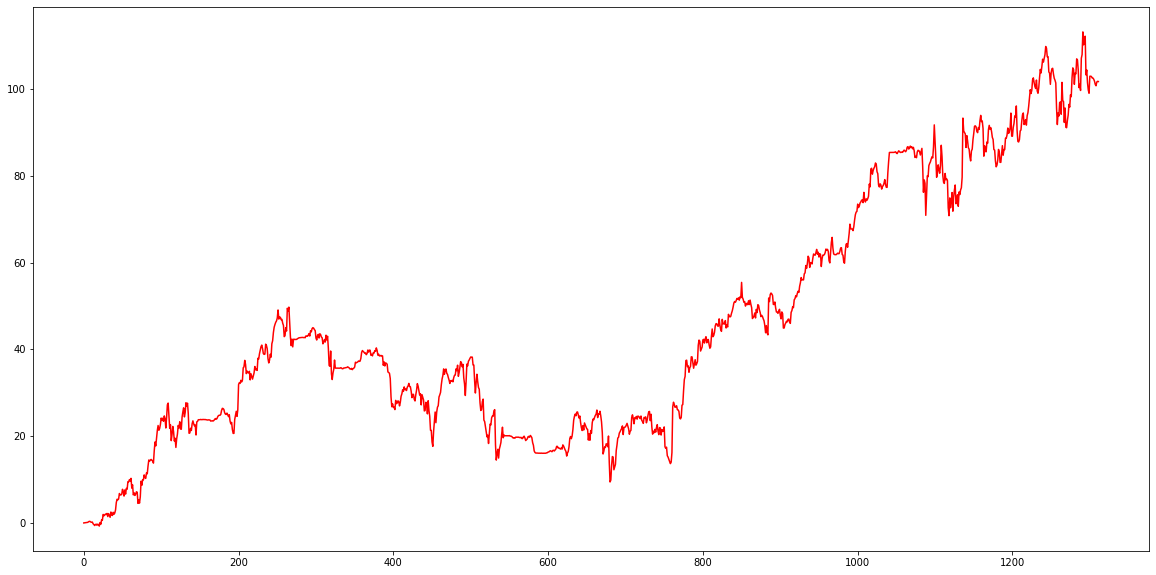

day 1510: buy 66 units at price 3877.500000, total balance 96122.500000
day 1511: buy 1 units at price 59.000000, total balance 96063.500000
day 1512: buy 50 units at price 2980.500000, total balance 93083.000000
day 1514: buy 44 units at price 2648.800000, total balance 90434.200000
day 1515: buy 46 units at price 2771.960000, total balance 87662.240000
day 1516: buy 59 units at price 3586.610000, total balance 84075.630000
day 1517: buy 37 units at price 2265.880000, total balance 81809.750000
day 1518: buy 18 units at price 1101.780000, total balance 80707.970000
day 1519: buy 67 units at price 4070.920000, total balance 76637.050000
day 1521: buy 13 units at price 789.620000, total balance 75847.430000
day 1522: buy 66 units at price 3945.480000, total balance 71901.950000
day 1523: buy 34 units at price 2019.600000, total balance 69882.350000
day 1524: buy 64 units at price 3771.520000, total balance 66110.830000
day 1526: buy 38 units at price 2261.000000, total balance 63849.830

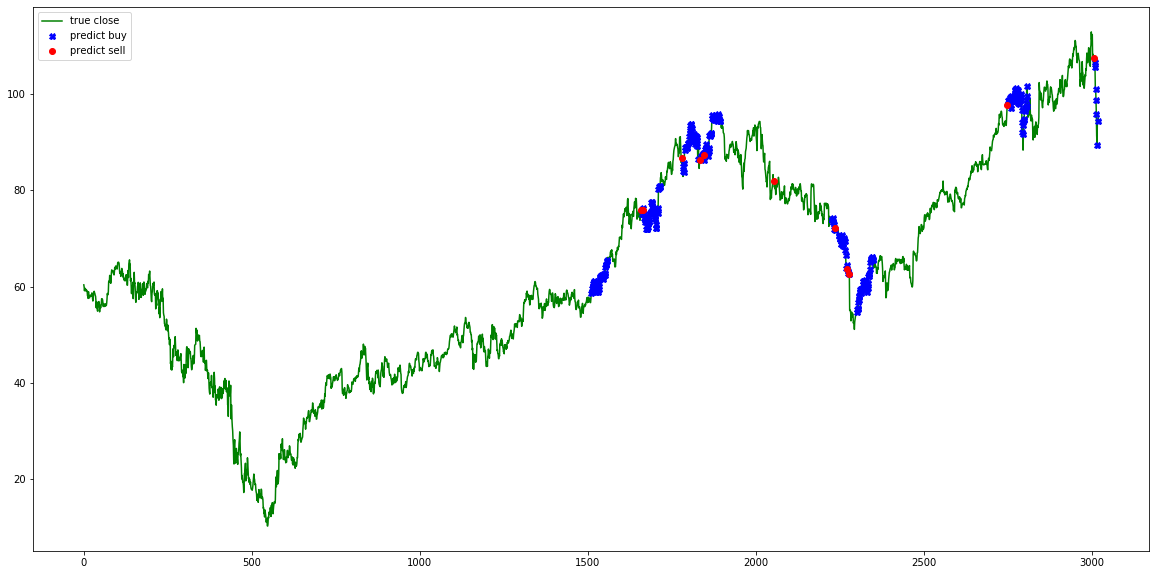

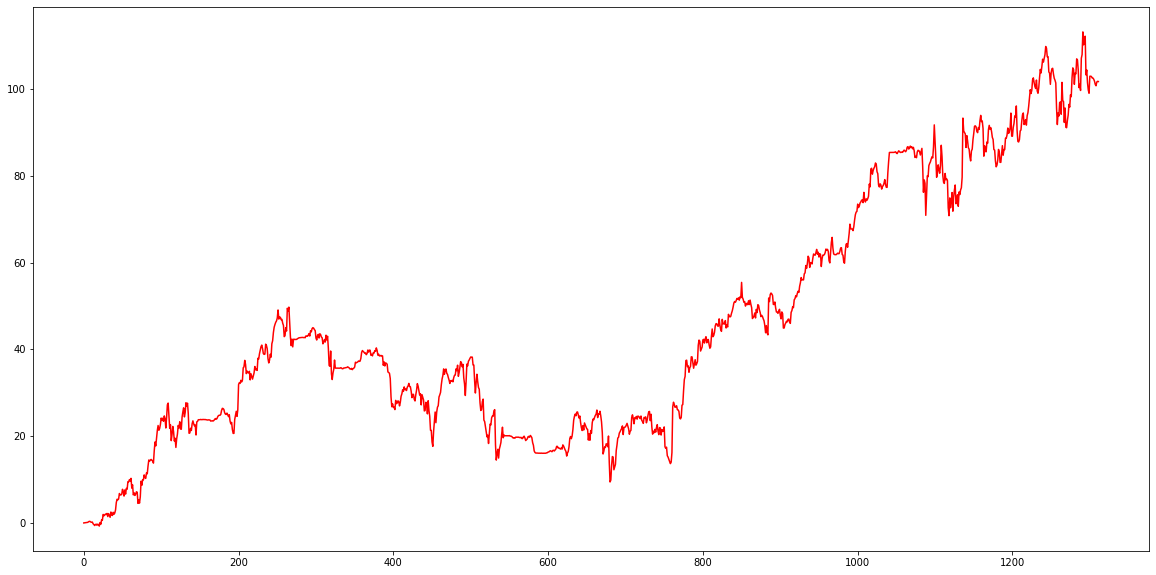

time taken to train: 1137.8218381404877 seconds


In [46]:
model = Model(input_size = 30*3, 
              layer_size = 500, 
              output_size = 3)
agent = Agent(population_size = 15, 
              sigma = 0.5, 
              learning_rate = 0.02, 
              model = model, 
              money = 100000,  
              skip = 1, 
              window_size = 30)
agent.fit(200, 5)

In [0]:
model = Model(input_size = int(np.around(NN_BAYESIAN.max['params']['window_size']))*4, 
              layer_size = int(np.around(NN_BAYESIAN.max['params']['size_network'])), 
              output_size = 3)
agent = Agent(population_size = int(np.around(NN_BAYESIAN.max['params']['population_size'])), 
              sigma = NN_BAYESIAN.max['params']['sigma'], 
              learning_rate = NN_BAYESIAN.max['params']['learning_rate'], 
              model = model, 
              money = 100000, 
              skip = int(np.around(NN_BAYESIAN.max['params']['skip'])), 
              window_size = int(np.around(NN_BAYESIAN.max['params']['window_size'])))
agent.fit(500, 100)